In [1]:
from PIL import Image
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm


# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model

# tensorflow layers
from tensorflow.keras import layers, Model
# VGG19
from tensorflow.keras.applications.vgg19 import VGG19

## GIF to Sequential Dataset(Frame by Frame)

In [2]:
def extract_frames_from_gif(gif_path, output_dir, target_frames=10):
    """
    GIF 파일에서 각 Frame을 추출하여 지정된 폴더에 저장하는 함수
    모든 GIF 파일을 동일한 프레임 수로 맞추기 위해 Interpolate을 사용 (?)
    """
    
    gif = Image.open(gif_path)
    total_frames = gif.n_frames # 전체 Frame 수
    print('Total Frames of the GIF : ', total_frames)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    extracted_frames = []
    for frame in range(total_frames):
        gif.seek(frame)
        frame_img = gif.convert('RGBA')
        extracted_frames.append(frame_img)
        
        
    # Frame 수 조정 (Interpolate / Selection)
    if total_frames < target_frames:
        # 프레임이 부족한 경우 -> Random으로 중간 프레임 Duplicate
        while len(extracted_frames) < target_frames:
            random_idx = random.randint(1, total_frames - 2) # Exclude First & Last Frame
            extracted_frames.insert(random_idx, extracted_frames[random_idx])
            
    elif total_frames > target_frames:
        # 프레임이 많은 경우 -> Random Selection
        step = total_frames / target_frames # Frame 간격
        selected_indices = sorted(random.sample(range(1, total_frames  - 1), total_frames - target_frames))        
           
        extracted_frames = [frame for i, frame in enumerate(extracted_frames) if i not in selected_indices]
    
    extracted_frames = extracted_frames[:target_frames]
    
    for idx, frame in enumerate(extracted_frames):
        frame.save(os.path.join(output_dir, f'{idx}.png'), 'PNG')

In [3]:
def convert_gif_to_frames(gif_path, output_dir):
    """
    GIF 파일에서 각 Frame을 추출하여 지정된 폴더에 저장하는 함수
    모든 GIF 파일을 동일한 프레임 수로 맞추기 위해 Interpolate을 사용 (?)
    """
    
    gif = Image.open(gif_path)
    total_frames = gif.n_frames # 전체 Frame 수
    print('Total Frames of the GIF : ', total_frames)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    extracted_frames = []
    for frame in range(total_frames):
        gif.seek(frame)
        frame_img = gif.convert('RGBA')
        extracted_frames.append(frame_img)
    
    for idx, frame in enumerate(extracted_frames):
        frame.save(os.path.join(output_dir, f'{idx}.png'), 'PNG')

In [146]:
gif_path = 'Dataset/Jump/npc_jump_1.gif'
output_dir = 'Frame_Img/Jump/npc_jump_1'
convert_gif_to_frames(gif_path, output_dir)

Total Frames of the GIF :  7


In [4]:
def character_coords(image_path, padding=10):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    coords = cv2.findNonZero(edges)
    x, y, w, h = cv2.boundingRect(coords)
    
    # x = max(0, x-padding)
    # y = max(0, y-padding)
    # w = min(image.shape[1]-x, w+2*padding)
    # h = min(image.shape[0]-y, h+2*padding)
    
    x1= max(0, x)
    y1= max(0, y)
    x2= min(image.shape[1], x+w)
    y2= min(image.shape[0], y+h)
    
    # cropped = image[y:y+h, x:x+w]
    cropped= image[y1:y2, x1:x2]
    
    if cropped.shape[2] == 4: # If Image is RGBA
        cropped = cv2.cvtColor(cropped, cv2.COLOR_BGRA2BGR)
    
    # return (x, y, w, h), cropped
    return ((x1, y1), (x2, y2)), cropped

def interpolate_positions(pos1, pos2, num_interpolations=1):
    """
    두 위치 좌표 (x, y)를 선형 보간하여 중간 위치를 생성하는 함수.
    """
    # x1, y1, w1, h1 = pos1
    # x2, y2, w2, h2 = pos2
    (x1_start, y1_start), (x2_start, y2_start) = pos1
    (x1_end, y1_end), (x2_end, y2_end) = pos2
    
    interpolated_positions = []
    for i in range(1, num_interpolations + 1):
        alpha = i / (num_interpolations + 1)
        
        # x = int((1 - alpha) * x1 + alpha * x2)
        # y = int((1 - alpha) * y1 + alpha * y2)
        # w = int((1 - alpha) * w1 + alpha * w2)
        # h = int((1 - alpha) * h1 + alpha * h2)
        # interpolated_positions.append((x, y, w, h))
        
        x1 = int((1 - alpha) * x1_start + alpha * x1_end)
        y1 = int((1 - alpha) * y1_start + alpha * y1_end)
        x2 = int((1 - alpha) * x2_start + alpha * x2_end)
        y2 = int((1 - alpha) * y2_start + alpha * y2_end)
        interpolated_positions.append(((x1, y1), (x2, y2)))
    
    return interpolated_positions

# Linear Interpolation of Frames

def interpolate_frames(frame1_path, frame2_path, num_interpolations=1):
    """
    Apply Linear Interpolation between two Frames.
    To smooth the transition between two frames(motion of the character)
    
    Input:
    num_interpolations: Number of Interpolations between two frames
    
    ** 아직 저장하는 부분 구현 X
    
    Limits:
    1. 배경이 흰색이라고 가정
    2. Object Detection이 완벽하다는 가정
    3. 두 프레임의 캐릭터 크기가 동일하다는 가정이 빠져있음(현재는 첫번째 사진을 기준으로 사용)
    """
    
    # Original Images
    base_image = cv2.imread(frame1_path)
    end_image = cv2.imread(frame2_path)
    
    # Extract Character Coordinates
    pos1, cropped1 = character_coords(frame1_path)
    pos2, cropped2 = character_coords(frame2_path)
    
    # Interpolate Character Positions
    interpolated_positions = interpolate_positions(pos1, pos2, num_interpolations)

    frames = []
    
    base_image_copy = base_image.copy()
    # cv2.rectangle(base_image_copy, pos1[0], pos1[1], (0, 255, 0), 2)
    frames.append(base_image_copy)
    
    for (x1, y1), (x2, y2) in interpolated_positions:

        interpolated_frame = base_image.copy()
        
        (orig_x1, orig_y1), (orig_x2, orig_y2) = pos1
        cv2.rectangle(interpolated_frame, (orig_x1, orig_y1), (orig_x2, orig_y2), (255, 255, 255), -1)
        
        resized_character = cv2.resize(cropped1, (x2 - x1, y2 - y1))
        interpolated_frame[y1:y2, x1:x2] = resized_character
    
        # cv2.rectangle(interpolated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        frames.append(interpolated_frame)
    
    # 마지막 end_image에도 bounding box 추가
    (x1_end, y1_end), (x2_end, y2_end) = pos2
    # cv2.rectangle(end_image, (x1_end, y1_end), (x2_end, y2_end), (0, 255, 0), 2)
    frames.append(end_image)
    
    # 시각화
    plt.figure(figsize=(15, 5))
    for idx, frame in enumerate(frames):
        plt.subplot(1, len(frames), idx + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Frame {idx}')
    plt.show()

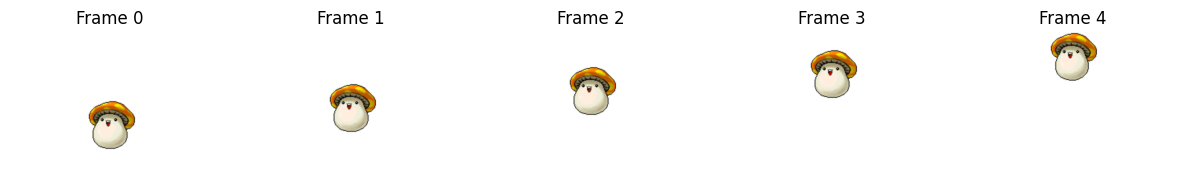

In [110]:
frame1_path = 'C:/Users/USER/Documents/Projects/Google_ML_BootCamp/NIPA/Frame_Img/Jump/npc_jump_1/5.png'
frame2_path = 'C:/Users/USER/Documents/Projects/Google_ML_BootCamp/NIPA/Frame_Img/Jump/npc_jump_1/6.png'
interpolate_frames(frame1_path, frame2_path, num_interpolations=3)

In [3]:
# extract_frames_from_gif('Dataset/Jump/npc_jump_1.gif', 'Frame_Img/Jump/npc_jump_1', 10)

In [4]:
# extract_frames_from_gif('Dataset/Jump/npc_jump_2.gif', 'Frame_Img/Jump/npc_jump_2', 10)

## Crop Charater From Image

In [5]:
def crop_to_character(image_path, padding=10):
    """
    이미지에서 캐릭터가 꽉 차도록 Crop하는 함수
    
    """
    
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # _, mask = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
    
    # coords = cv2.findNonZero(gray)
    # x, y, w, h = cv2.boundingRect(coords)
    edges = cv2.Canny(gray, 100, 200)  # Canny Edge Detection
    coords = cv2.findNonZero(edges)
    x, y, w, h = cv2.boundingRect(coords)
    
    # Bounding Box 주변에 padding 추가    
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] -  x, w + 2 * padding)
    h = min(image.shape[0] - y, h + 2 * padding)
    
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x+w, y+h), (0,255,0), 2)
    
    # Crop the image
    cropped = image[y:y+h, x:x+w]
    
    # Visualize
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image")
    plt.axis("off")
    
    plt.show()
    
    
    return cropped

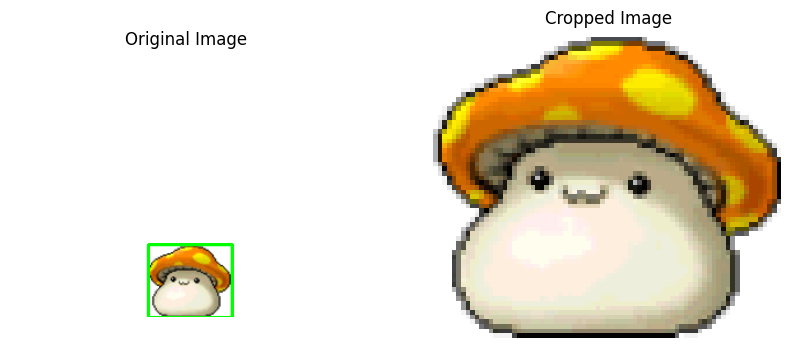

In [60]:
# crop_to_character('Frame_Img/Jump/npc_jump_1/0.png', 0)

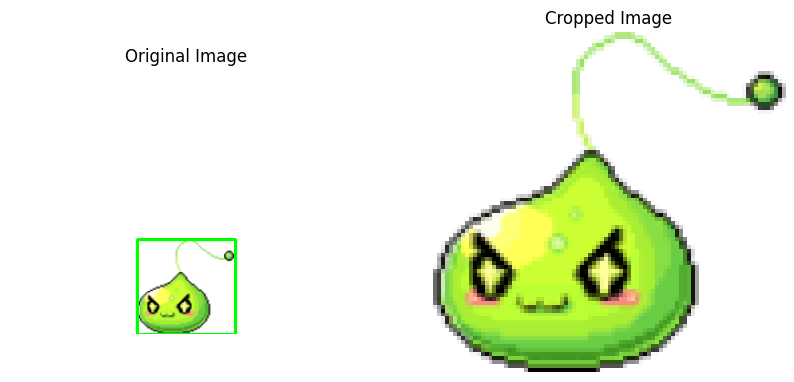

In [63]:
# crop_to_character('Frame_Img/Jump/npc_jump_2/0.png', 0)

## Data Preparation

In [6]:
def process_gif_to_dataset(gif_path, dataset_dir, target_frames=10, padding=10):
    """
    GAN + LSTM 모델 학습을 위한 데이터셋 준비 함수 
    
    Input : GIF Images (Sequence of Frames)
    Output : Character Image & Frame Images of Motion
    """
    
    frames_dir = os.path.join(dataset_dir)
    extract_frames_from_gif(gif_path, frames_dir, target_frames)
    
    cropped_frames_dir = os.path.join(dataset_dir)
    
    frame_path  = os.path.join(frames_dir, f'0.png')
    cropped_image = crop_to_character(frame_path, padding)
    
    input_image_path = os.path.join(cropped_frames_dir, f'{dataset_dir.split("/")[-1]}_Input.png')
    cv2.imwrite(input_image_path, cropped_image)
    
    print(f"Processed {gif_path} -> {cropped_frames_dir}")

Total Frames of the GIF :  7


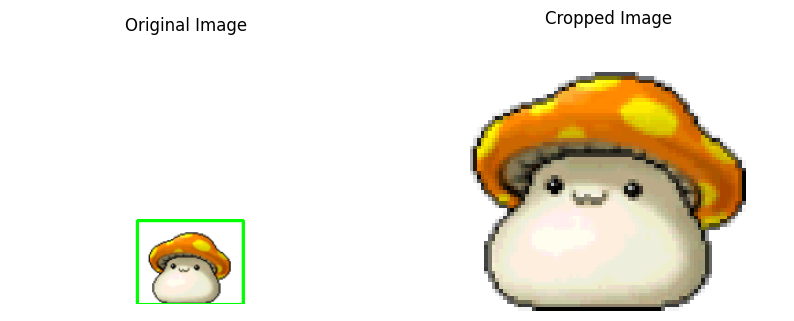

Processed Dataset/Jump/npc_jump_1.gif -> Frame_Img/Jump/npc_jump_1


In [7]:
gif_path = 'Dataset/Jump/npc_jump_1.gif'
dataset_dir = 'Frame_Img/Jump/npc_jump_1'
process_gif_to_dataset(gif_path, dataset_dir, target_frames=7, padding=10)

## Run Data Load

In [2]:
def label_to_one_hot(labels, num_classes, repeat):
  now_label_dataset = np.zeros((num_classes))
  now_label_dataset[labels]  = 1
  now_label_dataset = np.expand_dims(now_label_dataset, axis=0)
  now_label_dataset = np.repeat(now_label_dataset, repeats=repeat, axis=0)
  return now_label_dataset

In [3]:
def dataset_packing(path_npy, shuffle = False) :
  dataset = np.load(path_npy)
  # Split into train and validation sets using indexing to optimize memory.
  dataset = dataset/256
  x_dataset = dataset[:,0,:,:,:]
  y_dataset = dataset[:,1,:,:,:]
  rr  = x_dataset.shape[0]
  label_dataset = label_to_one_hot(1,10, rr)

  for i in range(8) :
    x_dataset = np.concatenate((x_dataset, dataset[:,0,:,:,:] ), axis = 0)
    y_dataset = np.concatenate((y_dataset, dataset[:,i+2,:,:,:] ), axis = 0)
    label_dataset = np.concatenate((label_dataset, label_to_one_hot(i + 2,10, rr)), axis = 0)

  print('data set shape----------------')
  print(x_dataset.shape)
  print(y_dataset.shape)
  print(label_dataset.shape)
  indexes = np.arange(x_dataset.shape[0])
  if shuffle :
    np.random.shuffle(indexes)

  x_train = x_dataset[indexes]
  y_train = y_dataset[indexes]
  label_train = label_dataset[indexes]

  print('train_data set shape----------------')
  print(x_train.shape)
  print(y_train.shape)
  print(label_train.shape)

  return x_train, y_train, label_train

In [4]:
import glob

def load_multiple_npy_files(directory_path):
    # directory_path에 있는 모든 .npy 파일 경로 가져오기
    file_paths = glob.glob(f"{directory_path}/*.npy")
    
    # 각 npy 파일을 로드하여 리스트에 추가
    datasets = [np.load(file) for file in file_paths]
    
    # 모든 npy 파일을 하나의 배열로 결합 (첫 번째 축을 기준으로)
    combined_dataset = np.concatenate(datasets, axis=0)
    
    return combined_dataset

In [5]:
combined_dataset = load_multiple_npy_files('Frame_Img/Walk/')   

In [6]:
combined_dataset.shape

(305, 10, 128, 128, 4)

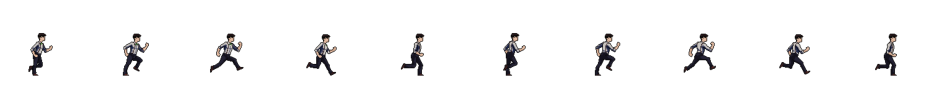

In [11]:
def visualize_rgba_dataset(dataset, batch_index=0, num_frames=10):
    # num_frames 개수만큼 샘플의 프레임을 시각화
    plt.figure(figsize=(12, 6))
    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)
        
        # (높이, 넓이, RGBA) 형식으로 프레임을 시각화
        plt.imshow(dataset[batch_index, i])  # 배치와 프레임 선택
        plt.axis('off')
    plt.show()

# 예시로 첫 번째 배치의 처음 5개 프레임 시각화
visualize_rgba_dataset(combined_dataset, batch_index=185, num_frames=10)

## GAN + LSTM
- Image -> Motion GIF (ex. Jump, Walk... etc)
- GAN은 Frame Generate + LSTM은 Sequence를 담당

#### **데이터셋 예시**

| **Input (Character Image)** | **Output (Frame Sequence - JUMP GIF)** |
|-----------------------------|----------------------------------------|
| `character_1.png`           | `jump_1/frame_1.png, jump_1/frame_2.png, ..., jump_1/frame_10.png` |
| `character_2.png`           | `jump_2/frame_1.png, jump_2/frame_2.png, ..., jump_2/frame_10.png` |
| `character_3.png`           | `jump_3/frame_1.png, jump_3/frame_2.png, ..., jump_3/frame_10.png` |
| `character_4.png`           | `jump_4/frame_1.png, jump_4/frame_2.png, ..., jump_4/frame_10.png` |
| `character_5.png`           | `jump_5/frame_1.png, jump_5/frame_2.png, ..., jump_5/frame_10.png` |

#### **설명**
- **Input (Character Image)**: 각 캐릭터의 정적 이미지 파일 이름입니다. 모델의 **입력**으로 사용됩니다.
- **Output (Frame Sequence - JUMP GIF)**: JUMP 동작을 표현하는 **10개의 연속된 프레임 이미지**입니다. 
  - 예를 들어, `jump_1` 폴더에는 `frame_1.png`부터 `frame_10.png`까지가 포함되어 있으며, 이는 `character_1.png`와 매칭됩니다.
  - 모든 출력 시퀀스는 동일한 길이의 프레임을 가지며, 이를 통해 모델이 정해진 시퀀스를 학습할 수 있게 됩니다.


Generator
- 독립적으로 입력된 캐릭터와 비슷한 이미지를 생성할 수 있는지 Test

**참고자료**
- https://velog.io/@hayaseleu/Transposed-Convolutional-Layer%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80

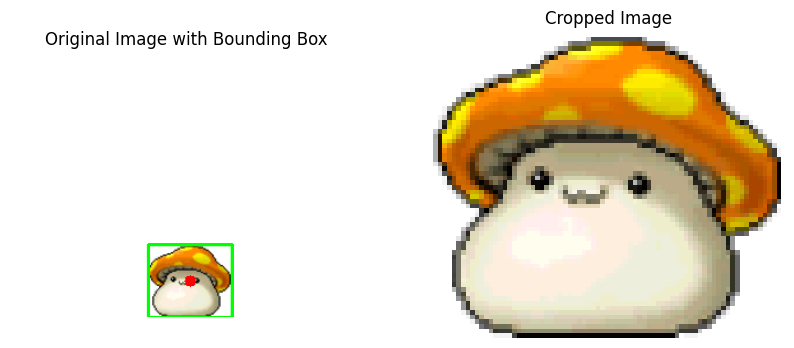

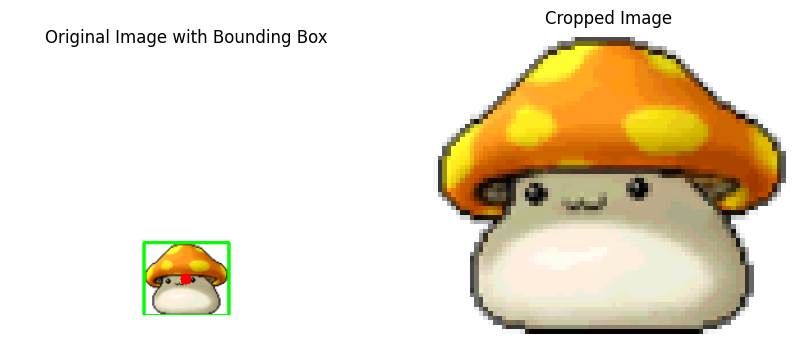

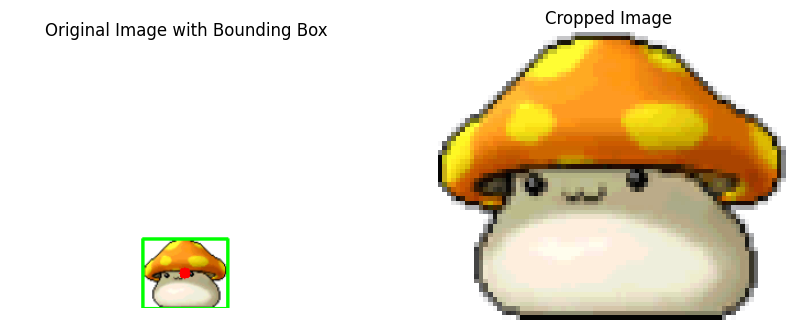

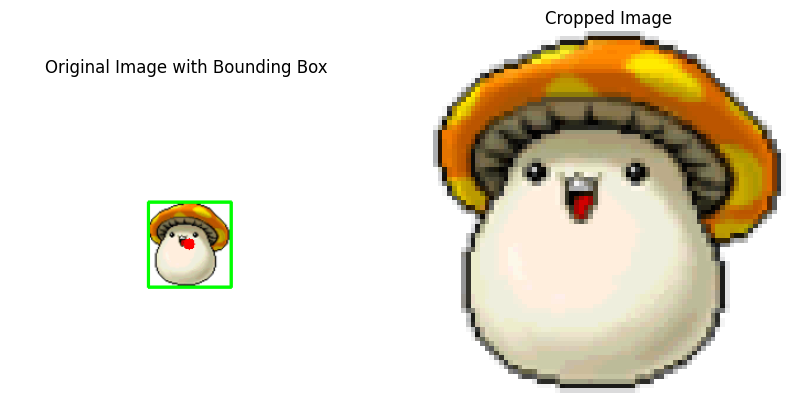

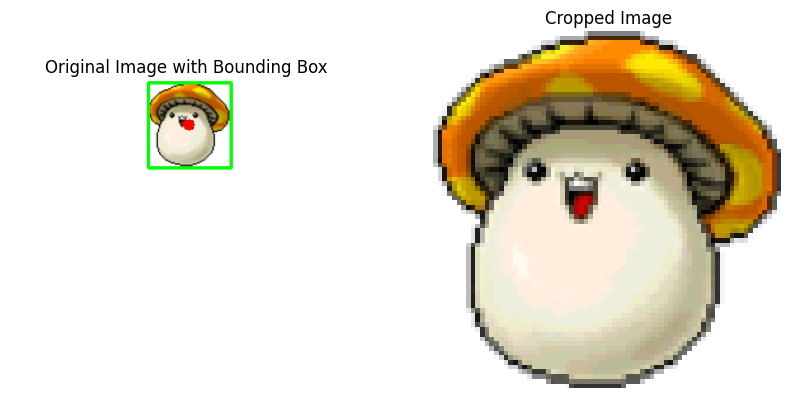

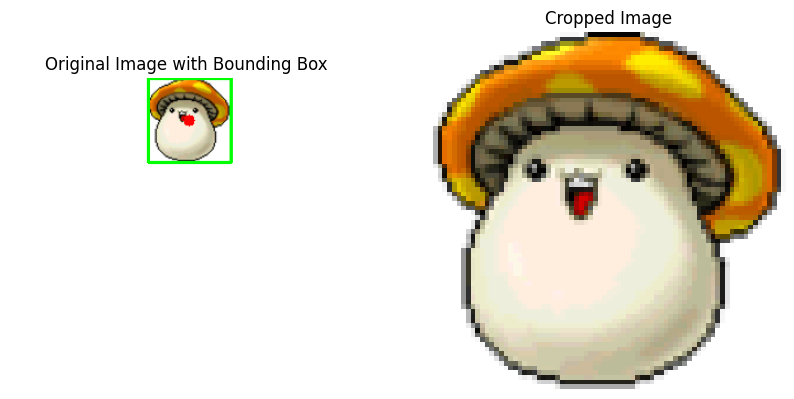

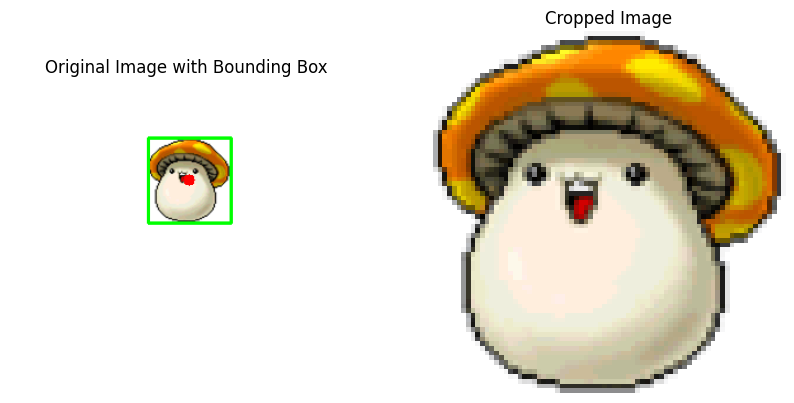

In [10]:
def coords_finder(image_path,padding=0):
    """
    이미지에서 캐릭터가 꽉 차도록 Crop하고, 좌표를 반환하는 함수
    좌표를 {frame_number}_position.txt 파일로 저장
    """
    
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    coords = cv2.findNonZero(edges)
    x, y, w, h = cv2.boundingRect(coords)
    
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(image.shape[1] -  x, w + 2 * padding)
    h = min(image.shape[0] - y, h + 2 * padding)
    
    center_x = x + w // 2
    center_y = y + h // 2

    frame_number = os.path.splitext(os.path.basename(image_path))[0] 
    position_path = os.path.join(os.path.dirname(image_path), f"{frame_number}_position.txt")
    # with open(position_path, "w") as f:
    #     f.write(f"{center_x},{center_y}")
    
    # 이미지 Crop
    cropped = image[y:y+h, x:x+w]
    
    cropped_image_path = os.path.join(f"C:/Users/USER/Documents/Projects/Google_ML_BootCamp/NIPA/Frame_Img/Jump/Sample/{frame_number}_cropped.png")
    cv2.imwrite(cropped_image_path, cropped)
    
        
    # 시각화
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.circle(image_with_bbox, (center_x, center_y), 5, (0, 0, 255), -1)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Bounding Box")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image")
    plt.axis("off")
    
    plt.show()
    
    return cropped
    

# Frame 경로 예시
dataset_dir = "Frame_Img/Jump/npc_jump_1"
for i in range(7):
    image_path = os.path.join(dataset_dir, f"{i}.png")
    if os.path.exists(image_path):
        coords_finder(image_path)
    else:
        print(f"Image {image_path} not found.")

In [ ]:
class Ayo_Generator(Model):
    """
    Generator Model for GAN
    "이미지를 GIF로 생성하는 모델"
    : Mixture of CNN, Attention Layer, LSTM for Frame Generation
    
    Input:
    - sequence_length: Number of Frames to Generate
    
    Output:
    - Generated Frames (Motion of Train GIF)
    """
    def __init__(self, sequence_length=7):
        super(Ayo_Generator, self).__init__()
        self.sequence_length = sequence_length

        # UNet Encoder
        self.encoder_layers = [
            layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(512, kernel_size=4, strides=2, padding='same', activation='relu')
        ]

        # Dense layer to reduce features for LSTM input
        self.reduce_features = layers.Dense(128, activation='relu')

        # Frame index embedding layer
        self.frame_embedding = layers.Embedding(input_dim=10, output_dim=128)

        # Dense layer to match LSTM output to decoder input shape
        self.expand_layer = layers.Dense(16 * 16 * 128, activation='relu')

        # UNet Decoder with skip connections
        self.decoder_layers = [
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(4, kernel_size=4, strides=1, padding='same', activation='tanh')
        ]

        # Layers to match skip connection channels
        self.match_channels_layers = [
            layers.Conv2D(256, kernel_size=1, padding='same'),
            layers.Conv2D(128, kernel_size=1, padding='same'),
            layers.Conv2D(64, kernel_size=1, padding='same')
        ]


    def call(self, input_image, frame_index):
        x = input_image
        skip_connections = []

        # Encoder with skip connections
        for layer in self.encoder_layers:
            x = layer(x)
            skip_connections.append(x)

        # Flatten and reduce to match LSTM input size
        features = tf.keras.layers.Flatten()(x)
        features = self.reduce_features(features)  # (batch_size, 128)

        # Expand frame_index to match the batch size
        frame_index = tf.reshape(frame_index, (-1, 1))  # Reshape to (batch_size, 1)
        frame_embedding = self.frame_embedding(frame_index)  # Get embeddings
        frame_embedding = tf.squeeze(frame_embedding, axis=1)  # Remove extra dimension after embedding

        # Concatenate features with frame embedding
        combined_features = tf.concat([features, frame_embedding], axis=-1)

        # Expand combined features to decoder input shape
        lstm_output_expanded = self.expand_layer(combined_features)
        x = tf.reshape(lstm_output_expanded, (-1, 16, 16, 128))

        # Decoder with skip connections
        for i, layer in enumerate(self.decoder_layers):
            if i < len(skip_connections):
                skip_connection = skip_connections[-(i + 1)]
                if i < len(self.match_channels_layers):
                    skip_connection = self.match_channels_layers[i](skip_connection)
                skip_connection = tf.image.resize(skip_connection, tf.shape(x)[1:3])
                x = tf.concat([x, skip_connection], axis=-1)
            x = layer(x)

        return x  # Return a single frame




class Ayo_Discriminator(Model):
    def __init__(self):
        super(Ayo_Discriminator, self).__init__()
        self.conv = tf.keras.Sequential([
            layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.Conv2D(256, kernel_size=4, strides=2, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])        

    def call(self, input_image, frames):
        # `frames`가 시퀀스인지 개별 프레임인지 확인
        if len(frames.shape) == 5:  # 시퀀스 (batch, sequence_length, height, width, channels)
            batch_size, sequence_length, height, width, channels = frames.shape
            input_resized = tf.image.resize(input_image, [height, width])
            input_resized = tf.expand_dims(input_resized, axis=1)
            input_resized = tf.tile(input_resized, [1, sequence_length, 1, 1, 1])
            
            outputs = []
            for i in range(sequence_length):
                frame = frames[:, i]
                combined = tf.concat([input_resized[:, i], frame], axis=-1)
                combined_resized = tf.image.resize(combined, [64, 64])
                output = self.conv(combined_resized)
                outputs.append(output)
            return tf.reduce_mean(outputs, axis=0)
        
        elif len(frames.shape) == 4:  # 개별 프레임 (batch, height, width, channels)
            batch_size, height, width, channels = frames.shape
            input_resized = tf.image.resize(input_image, [height, width])
            combined = tf.concat([input_resized, frames], axis=-1)
            combined_resized = tf.image.resize(combined, [64, 64])
            return self.conv(combined_resized)



batch_size = 32

def build_vgg19_perceptual_loss():
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    selected_layer = ['block4_conv2']
    outputs = [vgg.get_layer(name).output for name in selected_layer]
    model = Model(inputs=vgg.input, outputs=outputs)
    model.trainable = False
    
    return model

vgg_for_perceptual_loss = build_vgg19_perceptual_loss()    
    
# Loss Functions
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def perceptual_loss(real_images, generated_images, perceptual_weight=0.1):
    # real_images와 generated_images의 shape 확인 및 4차원인지 5차원인지에 따른 처리
    if len(real_images.shape) == 5:  # 시퀀스인 경우 (batch_size, sequence_length, height, width, channels)
        sequence_length = real_images.shape[1]
        
        # 각 프레임에 대해 Perceptual Loss를 계산
        perc_loss = 0
        for i in range(sequence_length):
            real_frame = real_images[:, i, :, :, :3]  # 첫 3 채널(RGB)만 선택
            generated_frame = generated_images[:, i, :, :, :3]  # 첫 3 채널(RGB)만 선택
            
            real_features = vgg_for_perceptual_loss(real_frame)
            generated_features = vgg_for_perceptual_loss(generated_frame)
            
            perc_loss += tf.reduce_mean(tf.square(real_features - generated_features))

        # 프레임 수에 따라 평균 내기
        perc_loss = perc_loss / sequence_length * perceptual_weight
        return perc_loss

    elif len(real_images.shape) == 4:  # 단일 프레임인 경우 (batch_size, height, width, channels)
        real_features = vgg_for_perceptual_loss(real_images[:, :, :, :3])
        generated_features = vgg_for_perceptual_loss(generated_images[:, :, :, :3])
        
        # 단일 프레임에 대한 Perceptual Loss 계산
        perc_loss = tf.reduce_mean(tf.square(real_features - generated_features)) * perceptual_weight
        return perc_loss

    
def generator_loss(fake_output, real_images, generated_images, sim_weight=1.0, consistency_weight=1.0, perceptual_weight=0.1):
    bce = bce_loss(tf.ones_like(fake_output), fake_output)
    frame_sim_loss = tf.reduce_mean(tf.square(real_images - generated_images)) * sim_weight

    # Temporal Consistency Loss
    consistency_loss = tf.reduce_mean(
        [tf.square(generated_images[:, i+1] - generated_images[:, i]) for i in range(generated_images.shape[1] - 1)]
    ) * consistency_weight

    # Perceptual Loss 추가
    perc_loss = perceptual_loss(real_images, generated_images, perceptual_weight)

    return bce + frame_sim_loss + consistency_loss + perc_loss


def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1=0.5)

num_frames = 10
generators = [Ayo_Generator(sequence_length=1) for _ in range(num_frames)]

# Training Step
def train_step_per_frame(generators, discriminator, real_images, input_image):
    batch_size = real_images.shape[0]
    gen_losses = []
    disc_losses = []

    for frame_index in range(num_frames):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_frame = generators[frame_index](input_image, tf.constant([frame_index] * batch_size))
            real_frame = real_images[:, frame_index]

            if frame_index == 0:
                continue
            
            real_output = discriminator(input_image, real_frame)
            fake_output = discriminator(input_image, generated_frame)

            gen_loss = generator_loss(fake_output, real_frame, generated_frame)
            disc_loss = discriminator_loss(real_output, fake_output)

            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        gradients_of_generator = gen_tape.gradient(gen_loss, generators[frame_index].trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generators[frame_index].trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    avg_gen_loss = tf.reduce_mean(gen_losses)
    avg_disc_loss = tf.reduce_mean(disc_losses)

    # numpy() 사용 가능
    print(f"Generator Loss: {avg_gen_loss.numpy()}, Discriminator Loss: {avg_disc_loss.numpy()}")
    return avg_gen_loss, avg_disc_loss




# Dataset Preparation
def load_real_data(combined_data, target_frames=10):
    # tf.data.Dataset API 사용하여 배치 로드 최적화
    def preprocess(data):
        data = tf.cast(data, tf.float32) / 127.5 - 1  # [-1, 1] 스케일링
        return data

    dataset = tf.data.Dataset.from_tensor_slices(combined_data)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


def visualize_sample(input_image, real_frames, generated_frames, epoch, batch_index, sequence_length=10):
    """
    Input 이미지와 생성된 Output 프레임을 시각화하여 확인
    """
    fig, axes = plt.subplots(3, sequence_length, figsize=(sequence_length * 2, 6))
    
    # 첫 번째 행: Input Image 한 장만 표시
    input_img = (input_image[0].numpy() + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
    for i in range(sequence_length):
        if i == 0:
            axes[0, i].imshow(input_img)
            axes[0, i].set_title(f"Epoch {epoch}, Batch {batch_index} - Input")
        else:
            axes[0, i].axis('off')  # 나머지 칸은 비워둠

    # 두 번째 행: Real Output Frames (실제 타겟 프레임들) 10장 모두 표시
    for idx in range(sequence_length):
        frame = (real_frames[0, idx].numpy() + 1) / 2
        axes[1, idx].imshow(frame)
        axes[1, idx].set_title(f"Real Frame {idx + 1}")
        axes[1, idx].axis('off')

    # 세 번째 행: Generated Frames (생성된 프레임들) 10장
    for idx in range(sequence_length):
        frame = (generated_frames[0, idx].numpy() + 1) / 2
        axes[2, idx].imshow(frame)
        axes[2, idx].set_title(f"Generated Frame {idx + 1}")
        axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    

def train_gan_per_frame(generators, discriminator, combined_data, epochs=5, target_frames=10, batch_size=16):
    gen_losses = []
    disc_losses = []

    # TensorFlow Dataset 구성
    dataset = tf.data.Dataset.from_tensor_slices(combined_data).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        batch_progress = tqdm(enumerate(dataset), total=len(dataset), desc=f"Processing Epoch {epoch + 1}/{epochs}", leave=False)
        
        for batch_index, real_images in batch_progress:
            real_images = tf.cast(real_images, tf.float32) / 127.5 - 1  # [-1, 1] 스케일링
            initial_image = real_images[:, 0]  # (batch_size, H, W, C), 첫 번째 프레임만 사용

            # 학습 단계 실행
            gen_loss, disc_loss = train_step_per_frame(generators, discriminator, real_images, initial_image)
            gen_losses.append(gen_loss.numpy())
            disc_losses.append(disc_loss.numpy())
            
            batch_progress.set_postfix({'Generator Loss': gen_loss.numpy(), 'Discriminator Loss': disc_loss.numpy()})

            # 10개 프레임 생성 및 시각화 (배치 인덱스 10 단위로 시각화)
            if batch_index % 10 == 0:
                generated_frames = [generators[i](initial_image, tf.constant([i] * batch_size)) for i in range(target_frames)]
                generated_frames = tf.stack(generated_frames, axis=1)  # (batch_size, target_frames, H, W, C)
                
                visualize_sample(initial_image, real_images, generated_frames, epoch + 1, batch_index, target_frames)
            
        # 매 50번째 에포크마다 생성된 샘플 확인
        if (epoch + 1) % 50 == 0:
            print(f"\nEpoch {epoch + 1}/{epochs} - Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    # 손실 그래프 표시
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.show()





def visualize_generated_images(generator, input_image, epoch, sequence_length=10):
    # Generator를 통해 프레임 생성
    generated_frames = generator(input_image)

    # 생성된 프레임들을 시각화하고 저장
    fig, axes = plt.subplots(1, sequence_length, figsize=(sequence_length * 2, 4))
    for i in range(sequence_length):
        frame = (generated_frames[0, i].numpy() + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
        axes[i].imshow(frame)
        axes[i].axis('off')
    plt.suptitle(f"Generated Frames at Epoch {epoch}")
    plt.tight_layout()
    # plt.savefig(f"{save_path}/generated_epoch_{epoch}.png")  # 에포크별 이미지 저장
    plt.show()
    
    
import matplotlib.pyplot as plt
import imageio

def generate_gif(generator, input_image, sequence_length=10, save_path="generated_gif.gif"):
    # Generator를 통해 프레임 생성
    generated_frames = generator(input_image)

    # 생성된 프레임들을 시각화하고 저장
    frames = []
    for i in range(sequence_length):
        frame = (generated_frames[0, i].numpy() + 1) / 2  # [-1, 1] 범위를 [0, 1]로 변환
        frames.append((frame * 255).astype(np.uint8))  # [0, 255]로 변환하여 uint8로 저장

    # GIF로 저장
    # imageio.mimsave(save_path, frames, fps=5)
    # print(f"GIF saved to {save_path}")

    # 생성된 GIF 미리보기
    plt.figure(figsize=(sequence_length * 2, 4))
    for i in range(sequence_length):
        plt.subplot(1, sequence_length, i + 1)
        plt.imshow(frames[i])
        plt.axis('off')
    plt.show()

Num GPUs Available:  1
Epoch 1/50


Processing Epoch 1/50:   0%|          | 0/20 [00:11<?, ?it/s, Generator Loss=17.3, Discriminator Loss=1.04]

Generator Loss: 17.253204345703125, Discriminator Loss: 1.0441516637802124


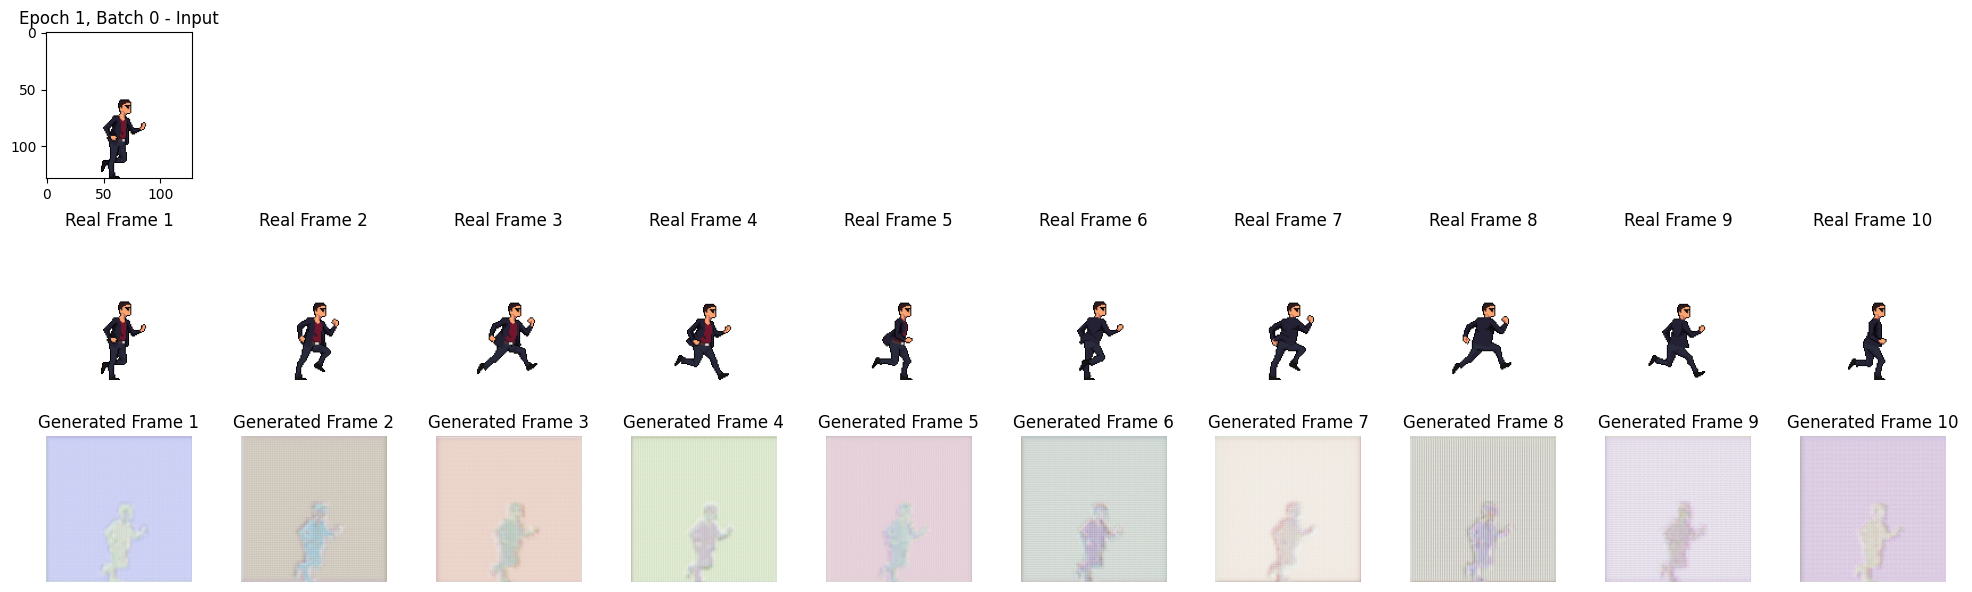

Processing Epoch 1/50:  10%|█         | 2/20 [00:17<02:20,  7.81s/it, Generator Loss=35.9, Discriminator Loss=0.000267]

Generator Loss: 35.90019607543945, Discriminator Loss: 0.000266898307017982


Processing Epoch 1/50:  15%|█▌        | 3/20 [00:21<01:44,  6.14s/it, Generator Loss=19.7, Discriminator Loss=4.63]    

Generator Loss: 19.65268325805664, Discriminator Loss: 4.6263885498046875


Processing Epoch 1/50:  20%|██        | 4/20 [00:25<01:25,  5.33s/it, Generator Loss=14.3, Discriminator Loss=1.69]

Generator Loss: 14.313047409057617, Discriminator Loss: 1.6948045492172241


Processing Epoch 1/50:  25%|██▌       | 5/20 [00:29<01:12,  4.85s/it, Generator Loss=9.86, Discriminator Loss=0.546]

Generator Loss: 9.860077857971191, Discriminator Loss: 0.5455783605575562


Processing Epoch 1/50:  30%|███       | 6/20 [00:33<01:03,  4.57s/it, Generator Loss=14, Discriminator Loss=0.000717]

Generator Loss: 14.02820873260498, Discriminator Loss: 0.0007167658768594265


Processing Epoch 1/50:  35%|███▌      | 7/20 [00:37<00:57,  4.40s/it, Generator Loss=17.5, Discriminator Loss=5.37]  

Generator Loss: 17.49372673034668, Discriminator Loss: 5.374367713928223


Processing Epoch 1/50:  40%|████      | 8/20 [00:41<00:51,  4.27s/it, Generator Loss=6.66, Discriminator Loss=1.64]

Generator Loss: 6.65807580947876, Discriminator Loss: 1.6404320001602173


Processing Epoch 1/50:  45%|████▌     | 9/20 [00:45<00:45,  4.17s/it, Generator Loss=9.31, Discriminator Loss=4]   

Generator Loss: 9.311212539672852, Discriminator Loss: 3.998727321624756


Processing Epoch 1/50:  50%|█████     | 10/20 [00:49<00:41,  4.13s/it, Generator Loss=9.03, Discriminator Loss=1.77]

Generator Loss: 9.02663803100586, Discriminator Loss: 1.7722129821777344


Processing Epoch 1/50:  50%|█████     | 10/20 [00:53<00:41,  4.13s/it, Generator Loss=5.77, Discriminator Loss=1.1] 

Generator Loss: 5.76520299911499, Discriminator Loss: 1.104499101638794


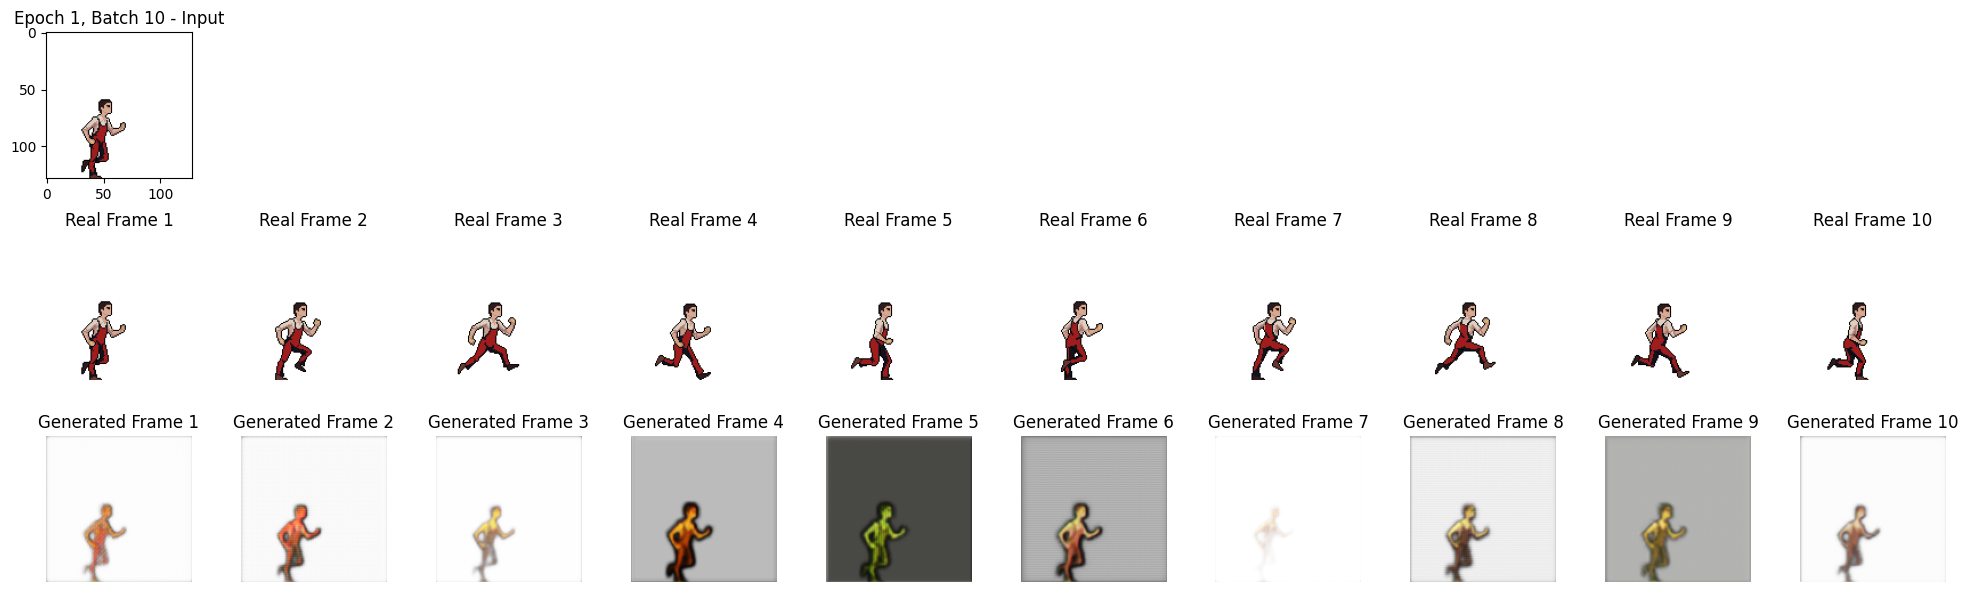

Processing Epoch 1/50:  60%|██████    | 12/20 [00:58<00:34,  4.34s/it, Generator Loss=6.31, Discriminator Loss=0.89]

Generator Loss: 6.308314323425293, Discriminator Loss: 0.8900993466377258


Processing Epoch 1/50:  65%|██████▌   | 13/20 [01:02<00:29,  4.26s/it, Generator Loss=9.02, Discriminator Loss=1.67]

Generator Loss: 9.023515701293945, Discriminator Loss: 1.6657922267913818


Processing Epoch 1/50:  70%|███████   | 14/20 [01:07<00:25,  4.21s/it, Generator Loss=5.69, Discriminator Loss=1.29]

Generator Loss: 5.689309597015381, Discriminator Loss: 1.2941598892211914


Processing Epoch 1/50:  75%|███████▌  | 15/20 [01:11<00:20,  4.14s/it, Generator Loss=5.37, Discriminator Loss=1.27]

Generator Loss: 5.367251396179199, Discriminator Loss: 1.2701027393341064


Processing Epoch 1/50:  80%|████████  | 16/20 [01:15<00:16,  4.09s/it, Generator Loss=6.92, Discriminator Loss=1.33]

Generator Loss: 6.921990871429443, Discriminator Loss: 1.328527569770813


Processing Epoch 1/50:  85%|████████▌ | 17/20 [01:19<00:12,  4.11s/it, Generator Loss=6.34, Discriminator Loss=1.26]

Generator Loss: 6.339293479919434, Discriminator Loss: 1.2643117904663086


Processing Epoch 1/50:  90%|█████████ | 18/20 [01:23<00:08,  4.09s/it, Generator Loss=4.81, Discriminator Loss=1.15]

Generator Loss: 4.812217712402344, Discriminator Loss: 1.1549320220947266


Processing Epoch 1/50:  95%|█████████▌| 19/20 [01:27<00:04,  4.05s/it, Generator Loss=5.27, Discriminator Loss=3.86]

Generator Loss: 5.265077114105225, Discriminator Loss: 3.8570613861083984


Generator Loss: 4.939882278442383, Discriminator Loss: 1.3893628120422363
Epoch 2/50


Processing Epoch 2/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=7.55, Discriminator Loss=1.33]

Generator Loss: 7.547468662261963, Discriminator Loss: 1.3284080028533936


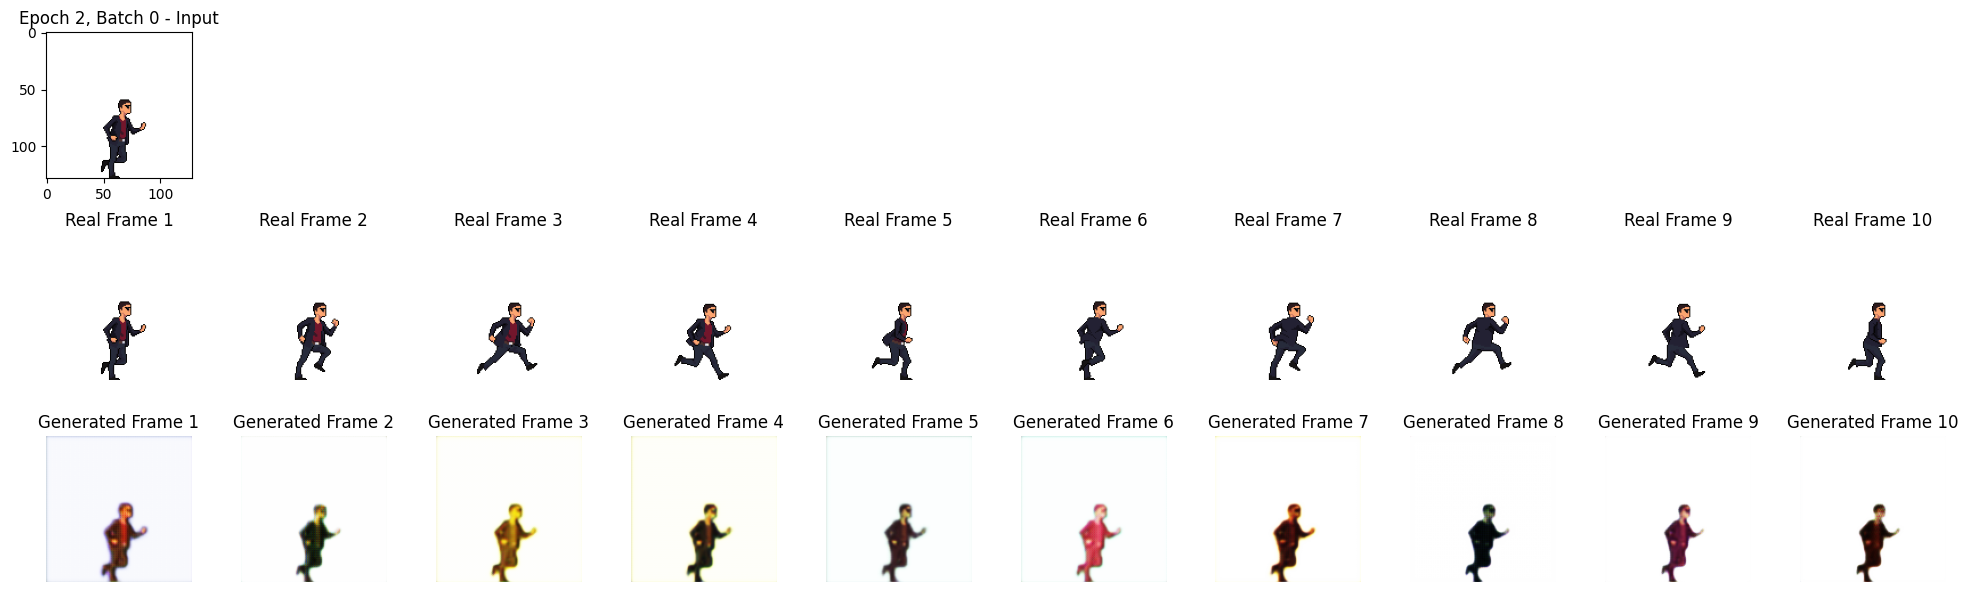

Processing Epoch 2/50:  10%|█         | 2/20 [00:10<01:26,  4.83s/it, Generator Loss=5.23, Discriminator Loss=1.3] 

Generator Loss: 5.228979110717773, Discriminator Loss: 1.3001753091812134


Processing Epoch 2/50:  15%|█▌        | 3/20 [00:14<01:17,  4.53s/it, Generator Loss=4.8, Discriminator Loss=1.27]

Generator Loss: 4.802970886230469, Discriminator Loss: 1.2722588777542114


Processing Epoch 2/50:  20%|██        | 4/20 [00:18<01:10,  4.38s/it, Generator Loss=7.49, Discriminator Loss=1.33]

Generator Loss: 7.494792938232422, Discriminator Loss: 1.330980896949768


Processing Epoch 2/50:  25%|██▌       | 5/20 [00:22<01:03,  4.23s/it, Generator Loss=4.82, Discriminator Loss=1.34]

Generator Loss: 4.816287040710449, Discriminator Loss: 1.3404287099838257


Processing Epoch 2/50:  30%|███       | 6/20 [00:26<00:57,  4.13s/it, Generator Loss=4.38, Discriminator Loss=1.36]

Generator Loss: 4.375091552734375, Discriminator Loss: 1.3612197637557983


Processing Epoch 2/50:  35%|███▌      | 7/20 [00:30<00:53,  4.10s/it, Generator Loss=6.5, Discriminator Loss=1.37] 

Generator Loss: 6.504208564758301, Discriminator Loss: 1.372145175933838


Processing Epoch 2/50:  40%|████      | 8/20 [00:34<00:49,  4.10s/it, Generator Loss=4.82, Discriminator Loss=0.929]

Generator Loss: 4.81893253326416, Discriminator Loss: 0.9292389154434204


Processing Epoch 2/50:  45%|████▌     | 9/20 [00:38<00:44,  4.05s/it, Generator Loss=5.39, Discriminator Loss=2.65] 

Generator Loss: 5.39293909072876, Discriminator Loss: 2.6523027420043945


Processing Epoch 2/50:  50%|█████     | 10/20 [00:42<00:40,  4.04s/it, Generator Loss=7.83, Discriminator Loss=1.93]

Generator Loss: 7.825791835784912, Discriminator Loss: 1.926868200302124


Processing Epoch 2/50:  50%|█████     | 10/20 [00:46<00:40,  4.04s/it, Generator Loss=5.15, Discriminator Loss=2.66]

Generator Loss: 5.145247459411621, Discriminator Loss: 2.6564407348632812


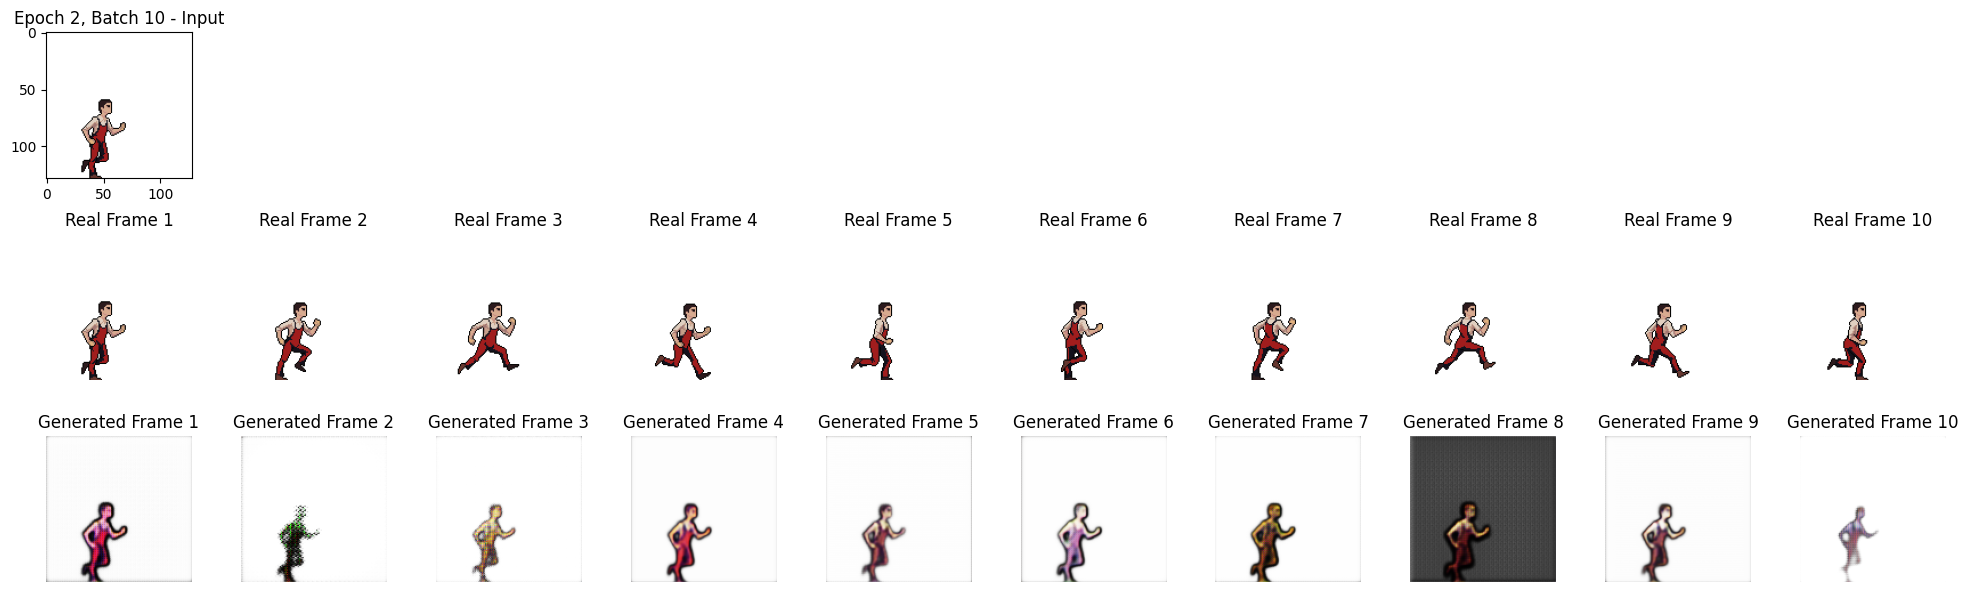

Processing Epoch 2/50:  60%|██████    | 12/20 [00:51<00:34,  4.30s/it, Generator Loss=4.8, Discriminator Loss=1.63] 

Generator Loss: 4.796926498413086, Discriminator Loss: 1.6338516473770142


Processing Epoch 2/50:  65%|██████▌   | 13/20 [00:55<00:29,  4.22s/it, Generator Loss=9.02, Discriminator Loss=1.26]

Generator Loss: 9.022120475769043, Discriminator Loss: 1.2631313800811768


Processing Epoch 2/50:  70%|███████   | 14/20 [00:59<00:25,  4.18s/it, Generator Loss=4.78, Discriminator Loss=1.04]

Generator Loss: 4.784134864807129, Discriminator Loss: 1.0425218343734741


Processing Epoch 2/50:  75%|███████▌  | 15/20 [01:03<00:20,  4.11s/it, Generator Loss=4.62, Discriminator Loss=1.56]

Generator Loss: 4.622636318206787, Discriminator Loss: 1.5575287342071533


Processing Epoch 2/50:  80%|████████  | 16/20 [01:07<00:16,  4.05s/it, Generator Loss=5.71, Discriminator Loss=1.37]

Generator Loss: 5.708365440368652, Discriminator Loss: 1.3699744939804077


Processing Epoch 2/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.06s/it, Generator Loss=5.65, Discriminator Loss=1.33]

Generator Loss: 5.645035266876221, Discriminator Loss: 1.3331406116485596


Processing Epoch 2/50:  90%|█████████ | 18/20 [01:15<00:08,  4.06s/it, Generator Loss=4.44, Discriminator Loss=1.23]

Generator Loss: 4.442067623138428, Discriminator Loss: 1.2304757833480835


Processing Epoch 2/50:  95%|█████████▌| 19/20 [01:19<00:04,  4.02s/it, Generator Loss=4.48, Discriminator Loss=1.7] 

Generator Loss: 4.48049259185791, Discriminator Loss: 1.6976425647735596


Generator Loss: 4.454528331756592, Discriminator Loss: 1.2828620672225952
Epoch 3/50


Processing Epoch 3/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=6.52, Discriminator Loss=1.14]

Generator Loss: 6.522261619567871, Discriminator Loss: 1.1402068138122559


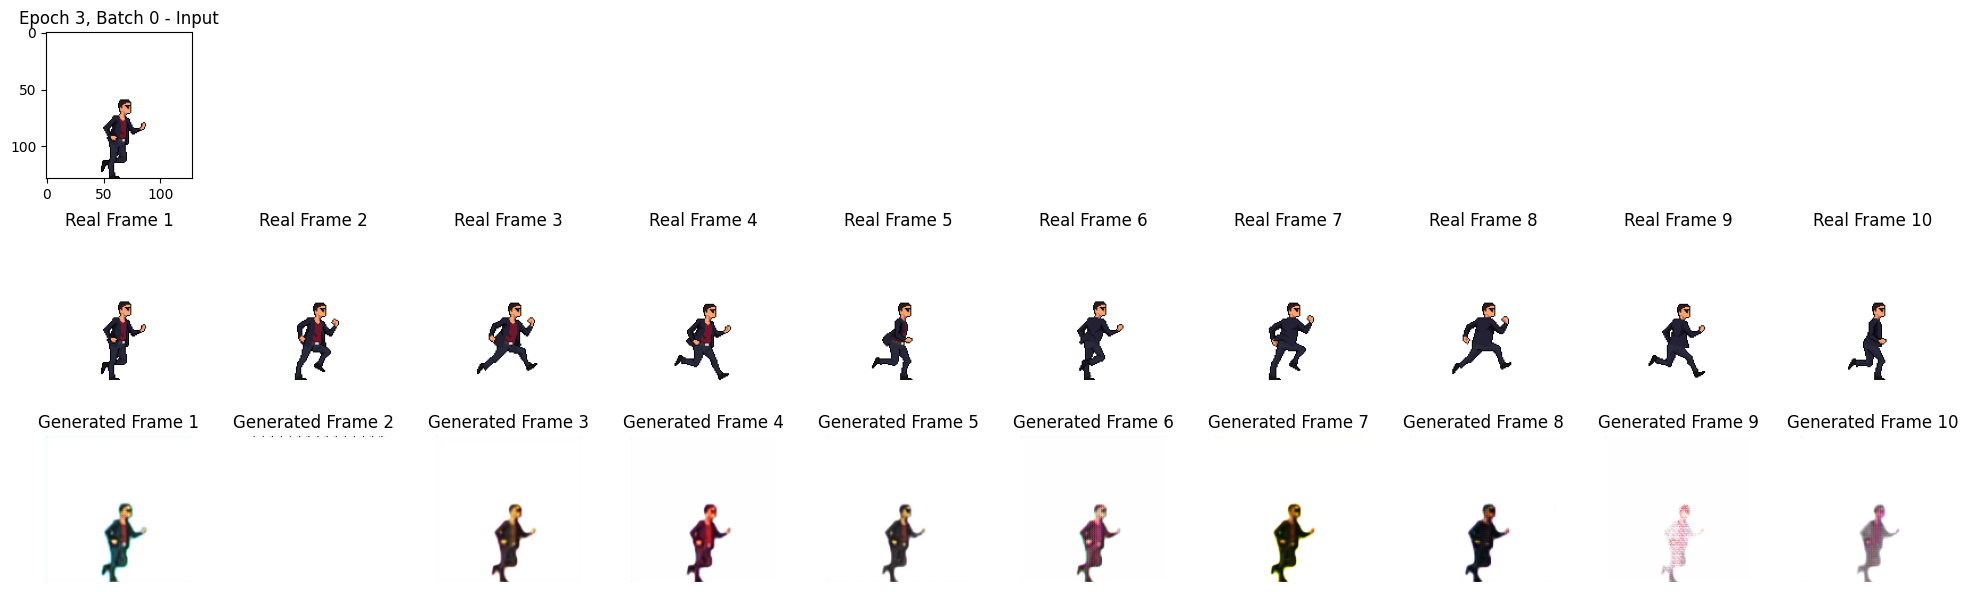

Processing Epoch 3/50:  10%|█         | 2/20 [00:09<01:24,  4.71s/it, Generator Loss=4.91, Discriminator Loss=1.08]

Generator Loss: 4.914731502532959, Discriminator Loss: 1.0828291177749634


Processing Epoch 3/50:  15%|█▌        | 3/20 [00:13<01:14,  4.40s/it, Generator Loss=4.88, Discriminator Loss=1.07]

Generator Loss: 4.884675025939941, Discriminator Loss: 1.0711662769317627


Processing Epoch 3/50:  20%|██        | 4/20 [00:17<01:08,  4.28s/it, Generator Loss=8.51, Discriminator Loss=1.02]

Generator Loss: 8.512483596801758, Discriminator Loss: 1.0168983936309814


Processing Epoch 3/50:  25%|██▌       | 5/20 [00:21<01:02,  4.19s/it, Generator Loss=5.94, Discriminator Loss=0.625]

Generator Loss: 5.9399094581604, Discriminator Loss: 0.6254308223724365


Processing Epoch 3/50:  30%|███       | 6/20 [00:25<00:57,  4.11s/it, Generator Loss=4.87, Discriminator Loss=1.33] 

Generator Loss: 4.865266799926758, Discriminator Loss: 1.3265092372894287


Processing Epoch 3/50:  35%|███▌      | 7/20 [00:29<00:53,  4.08s/it, Generator Loss=9.79, Discriminator Loss=1.58]

Generator Loss: 9.794337272644043, Discriminator Loss: 1.5780330896377563


Processing Epoch 3/50:  40%|████      | 8/20 [00:33<00:49,  4.08s/it, Generator Loss=6, Discriminator Loss=0.632]  

Generator Loss: 6.001682281494141, Discriminator Loss: 0.6324292421340942


Processing Epoch 3/50:  45%|████▌     | 9/20 [00:37<00:44,  4.04s/it, Generator Loss=5.74, Discriminator Loss=0.6]

Generator Loss: 5.74155330657959, Discriminator Loss: 0.5997629165649414


Processing Epoch 3/50:  50%|█████     | 10/20 [00:41<00:40,  4.02s/it, Generator Loss=7.87, Discriminator Loss=1.13]

Generator Loss: 7.874787330627441, Discriminator Loss: 1.1296050548553467


Processing Epoch 3/50:  50%|█████     | 10/20 [00:45<00:40,  4.02s/it, Generator Loss=7.61, Discriminator Loss=5.9] 

Generator Loss: 7.611088752746582, Discriminator Loss: 5.896401882171631


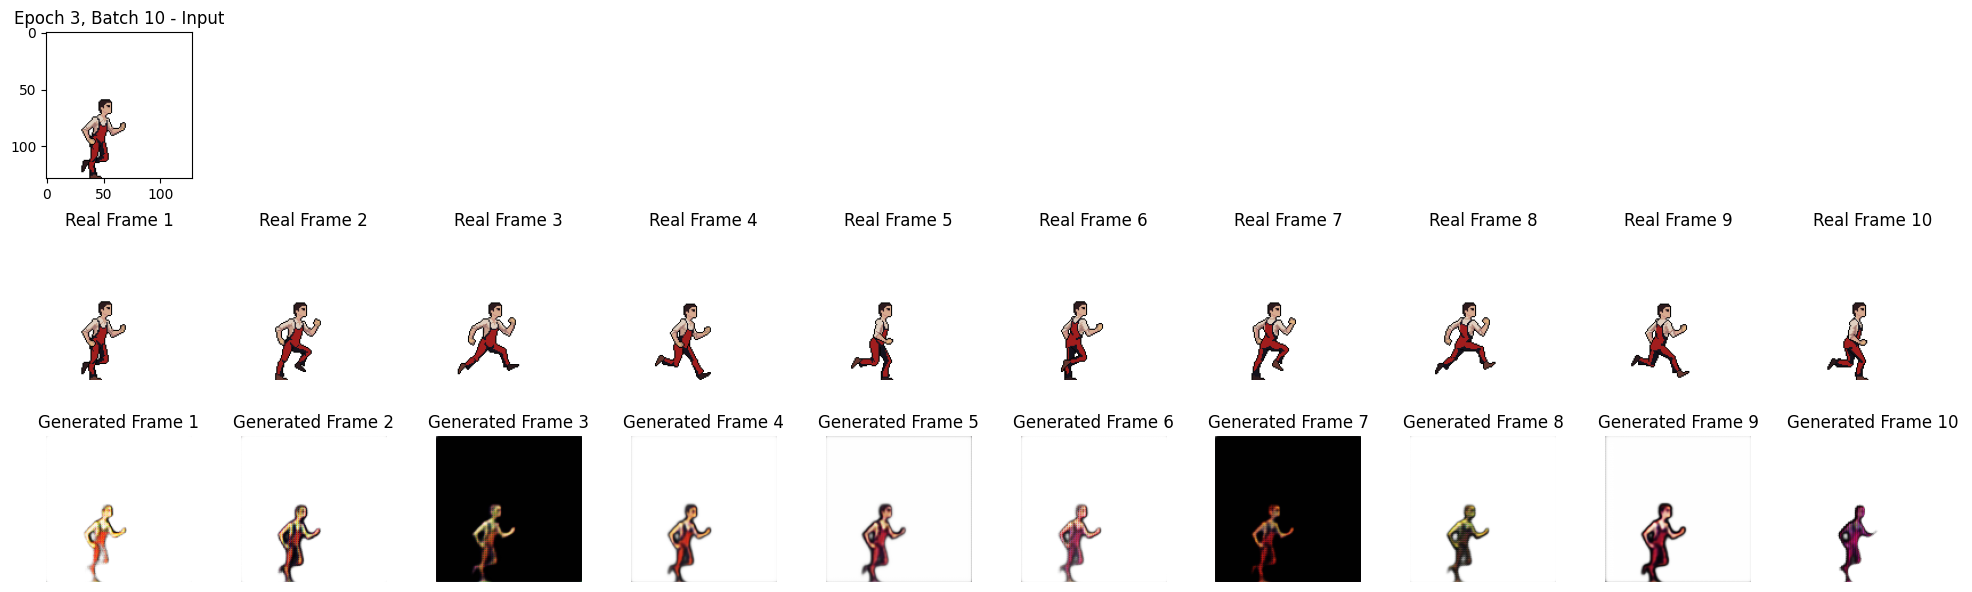

Processing Epoch 3/50:  60%|██████    | 12/20 [00:51<00:34,  4.29s/it, Generator Loss=4.68, Discriminator Loss=1.24]

Generator Loss: 4.678193092346191, Discriminator Loss: 1.23903489112854


Processing Epoch 3/50:  65%|██████▌   | 13/20 [00:55<00:29,  4.17s/it, Generator Loss=7.47, Discriminator Loss=1.19]

Generator Loss: 7.465307712554932, Discriminator Loss: 1.190709114074707


Processing Epoch 3/50:  70%|███████   | 14/20 [00:59<00:24,  4.13s/it, Generator Loss=6.25, Discriminator Loss=1.11]

Generator Loss: 6.251643180847168, Discriminator Loss: 1.1055396795272827


Processing Epoch 3/50:  75%|███████▌  | 15/20 [01:03<00:20,  4.10s/it, Generator Loss=4.93, Discriminator Loss=1.13]

Generator Loss: 4.927425384521484, Discriminator Loss: 1.1330596208572388


Processing Epoch 3/50:  80%|████████  | 16/20 [01:07<00:16,  4.05s/it, Generator Loss=6.41, Discriminator Loss=0.987]

Generator Loss: 6.408079624176025, Discriminator Loss: 0.9870810508728027


Processing Epoch 3/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.04s/it, Generator Loss=6.94, Discriminator Loss=0.864]

Generator Loss: 6.942608833312988, Discriminator Loss: 0.8641587495803833


Processing Epoch 3/50:  90%|█████████ | 18/20 [01:15<00:08,  4.05s/it, Generator Loss=8.02, Discriminator Loss=0.686]

Generator Loss: 8.0225248336792, Discriminator Loss: 0.6864099502563477


Processing Epoch 3/50:  95%|█████████▌| 19/20 [01:19<00:04,  4.04s/it, Generator Loss=11.5, Discriminator Loss=0.671]

Generator Loss: 11.486742973327637, Discriminator Loss: 0.6712124347686768


Generator Loss: 8.371914863586426, Discriminator Loss: 0.6896836757659912
Epoch 4/50


Processing Epoch 4/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=14.7, Discriminator Loss=0.843]

Generator Loss: 14.668661117553711, Discriminator Loss: 0.8428165316581726


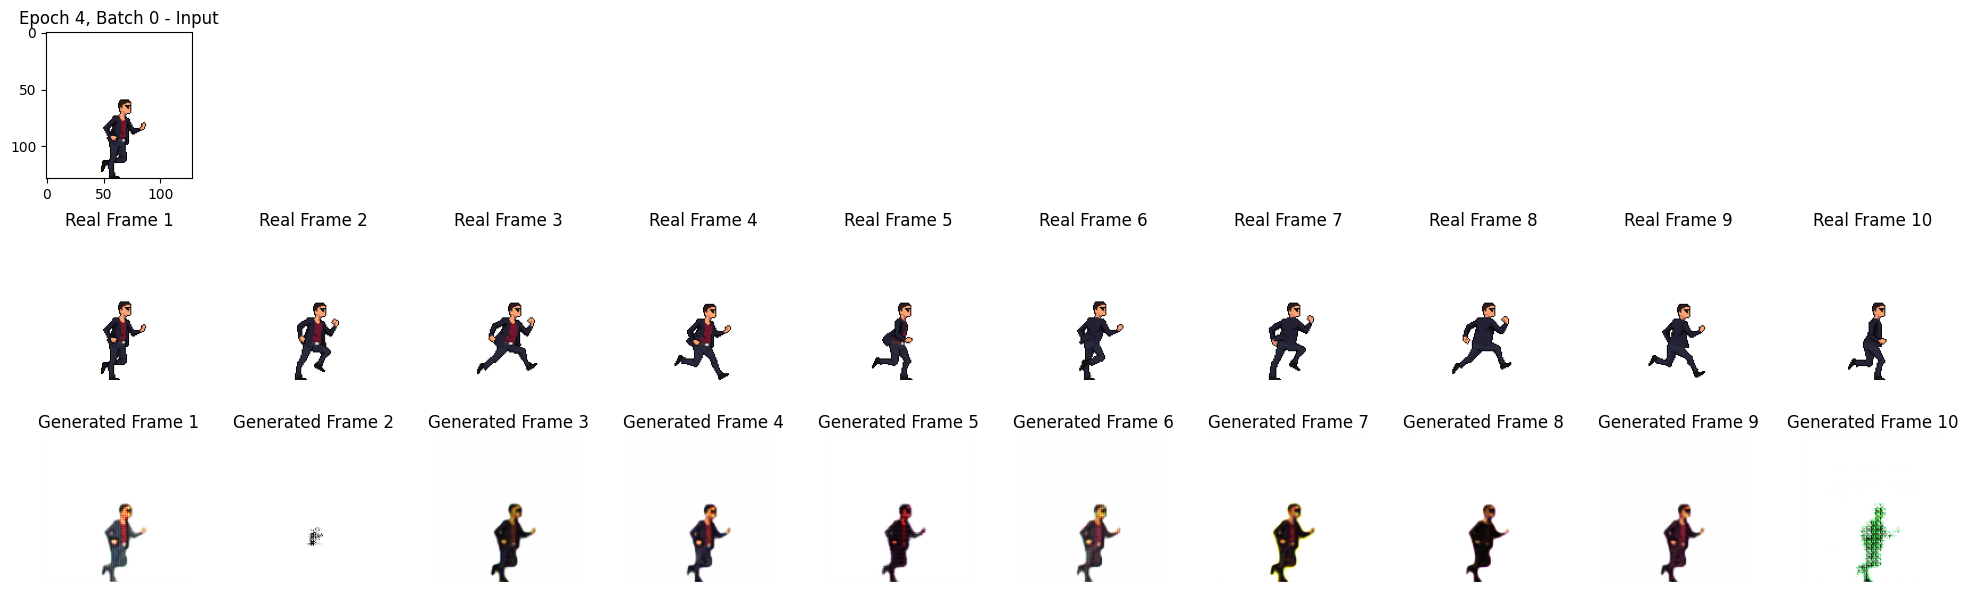

Processing Epoch 4/50:  10%|█         | 2/20 [00:09<01:26,  4.79s/it, Generator Loss=11.8, Discriminator Loss=0.573]

Generator Loss: 11.825296401977539, Discriminator Loss: 0.5728858709335327


Processing Epoch 4/50:  15%|█▌        | 3/20 [00:13<01:14,  4.40s/it, Generator Loss=11.5, Discriminator Loss=0.577]

Generator Loss: 11.478616714477539, Discriminator Loss: 0.5773372054100037


Processing Epoch 4/50:  20%|██        | 4/20 [00:17<01:08,  4.25s/it, Generator Loss=10.5, Discriminator Loss=0.845]

Generator Loss: 10.48508071899414, Discriminator Loss: 0.8447511792182922


Processing Epoch 4/50:  25%|██▌       | 5/20 [00:21<01:02,  4.19s/it, Generator Loss=12, Discriminator Loss=0.494]  

Generator Loss: 12.00477409362793, Discriminator Loss: 0.4944893419742584


Processing Epoch 4/50:  30%|███       | 6/20 [00:25<00:57,  4.12s/it, Generator Loss=11.5, Discriminator Loss=0.467]

Generator Loss: 11.467371940612793, Discriminator Loss: 0.46681880950927734


Processing Epoch 4/50:  35%|███▌      | 7/20 [00:29<00:52,  4.07s/it, Generator Loss=12.1, Discriminator Loss=0.795]

Generator Loss: 12.088685989379883, Discriminator Loss: 0.7952405214309692


Processing Epoch 4/50:  40%|████      | 8/20 [00:33<00:48,  4.07s/it, Generator Loss=10.6, Discriminator Loss=0.563]

Generator Loss: 10.591654777526855, Discriminator Loss: 0.5628637075424194


Processing Epoch 4/50:  45%|████▌     | 9/20 [00:37<00:44,  4.06s/it, Generator Loss=13.4, Discriminator Loss=0.543]

Generator Loss: 13.372302055358887, Discriminator Loss: 0.5430493354797363


Processing Epoch 4/50:  50%|█████     | 10/20 [00:41<00:40,  4.02s/it, Generator Loss=14.9, Discriminator Loss=0.67]

Generator Loss: 14.936525344848633, Discriminator Loss: 0.6702197790145874


Processing Epoch 4/50:  50%|█████     | 10/20 [00:45<00:40,  4.02s/it, Generator Loss=16.5, Discriminator Loss=0.469]

Generator Loss: 16.47848892211914, Discriminator Loss: 0.46903499960899353


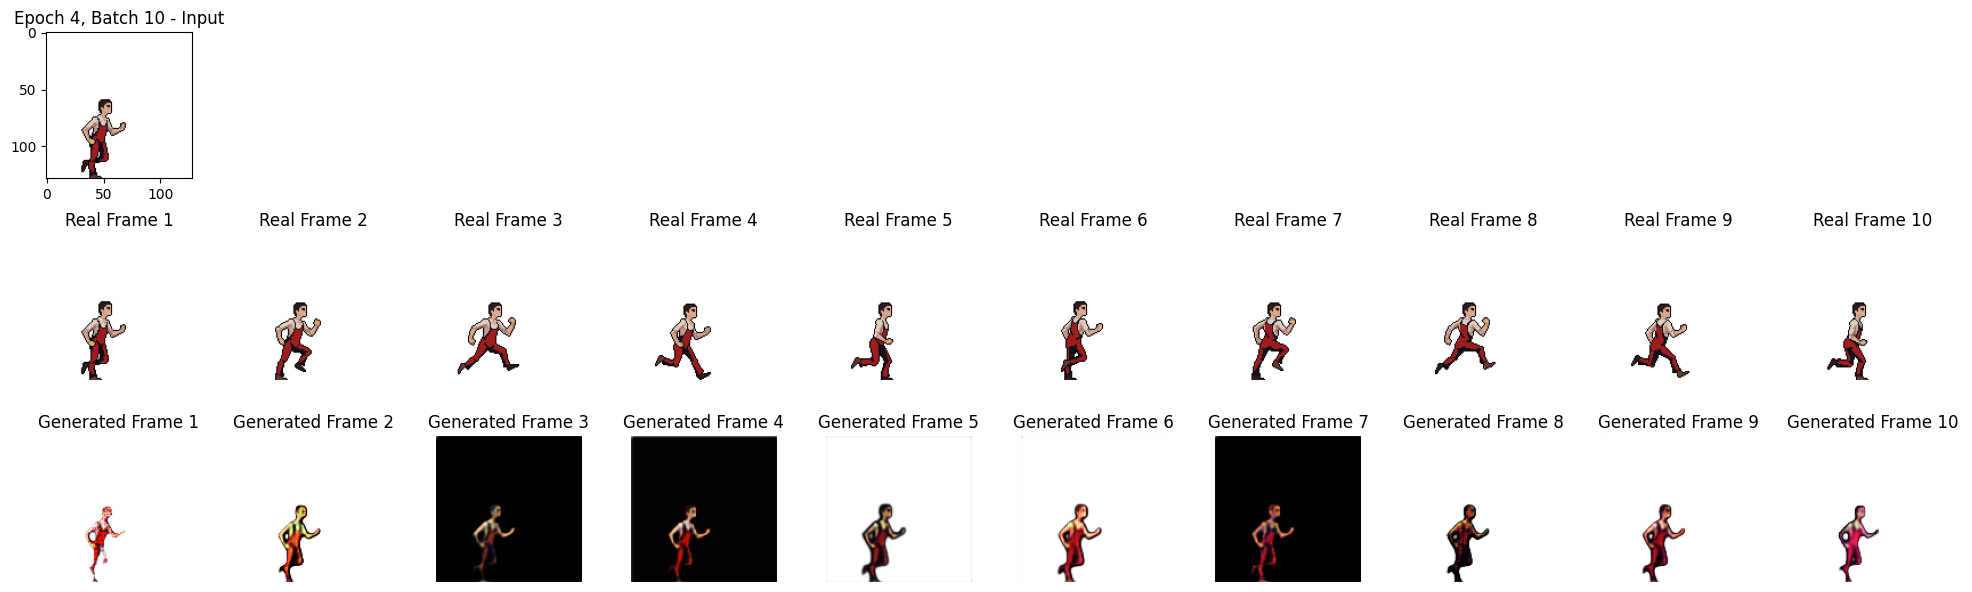

Processing Epoch 4/50:  60%|██████    | 12/20 [00:51<00:34,  4.30s/it, Generator Loss=12.7, Discriminator Loss=0.373]

Generator Loss: 12.650075912475586, Discriminator Loss: 0.37262582778930664


Processing Epoch 4/50:  65%|██████▌   | 13/20 [00:55<00:29,  4.20s/it, Generator Loss=14.7, Discriminator Loss=1.12] 

Generator Loss: 14.72569751739502, Discriminator Loss: 1.1231985092163086


Processing Epoch 4/50:  70%|███████   | 14/20 [00:59<00:24,  4.13s/it, Generator Loss=7.76, Discriminator Loss=0.491]

Generator Loss: 7.764930725097656, Discriminator Loss: 0.49118533730506897


Processing Epoch 4/50:  75%|███████▌  | 15/20 [01:03<00:20,  4.12s/it, Generator Loss=7.61, Discriminator Loss=0.48] 

Generator Loss: 7.608460426330566, Discriminator Loss: 0.47999611496925354


Processing Epoch 4/50:  80%|████████  | 16/20 [01:07<00:16,  4.09s/it, Generator Loss=8.27, Discriminator Loss=0.596]

Generator Loss: 8.268777847290039, Discriminator Loss: 0.5956423282623291


Processing Epoch 4/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.04s/it, Generator Loss=8.03, Discriminator Loss=0.566]

Generator Loss: 8.025733947753906, Discriminator Loss: 0.566358208656311


Processing Epoch 4/50:  90%|█████████ | 18/20 [01:15<00:08,  4.05s/it, Generator Loss=13.4, Discriminator Loss=0.506]

Generator Loss: 13.398828506469727, Discriminator Loss: 0.5056677460670471


Processing Epoch 4/50:  95%|█████████▌| 19/20 [01:19<00:04,  4.06s/it, Generator Loss=11.1, Discriminator Loss=0.524]

Generator Loss: 11.087577819824219, Discriminator Loss: 0.5235099792480469


Generator Loss: 14.3123197555542, Discriminator Loss: 0.547272801399231
Epoch 5/50


Processing Epoch 5/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=15.6, Discriminator Loss=0.916]

Generator Loss: 15.575094223022461, Discriminator Loss: 0.9158937335014343


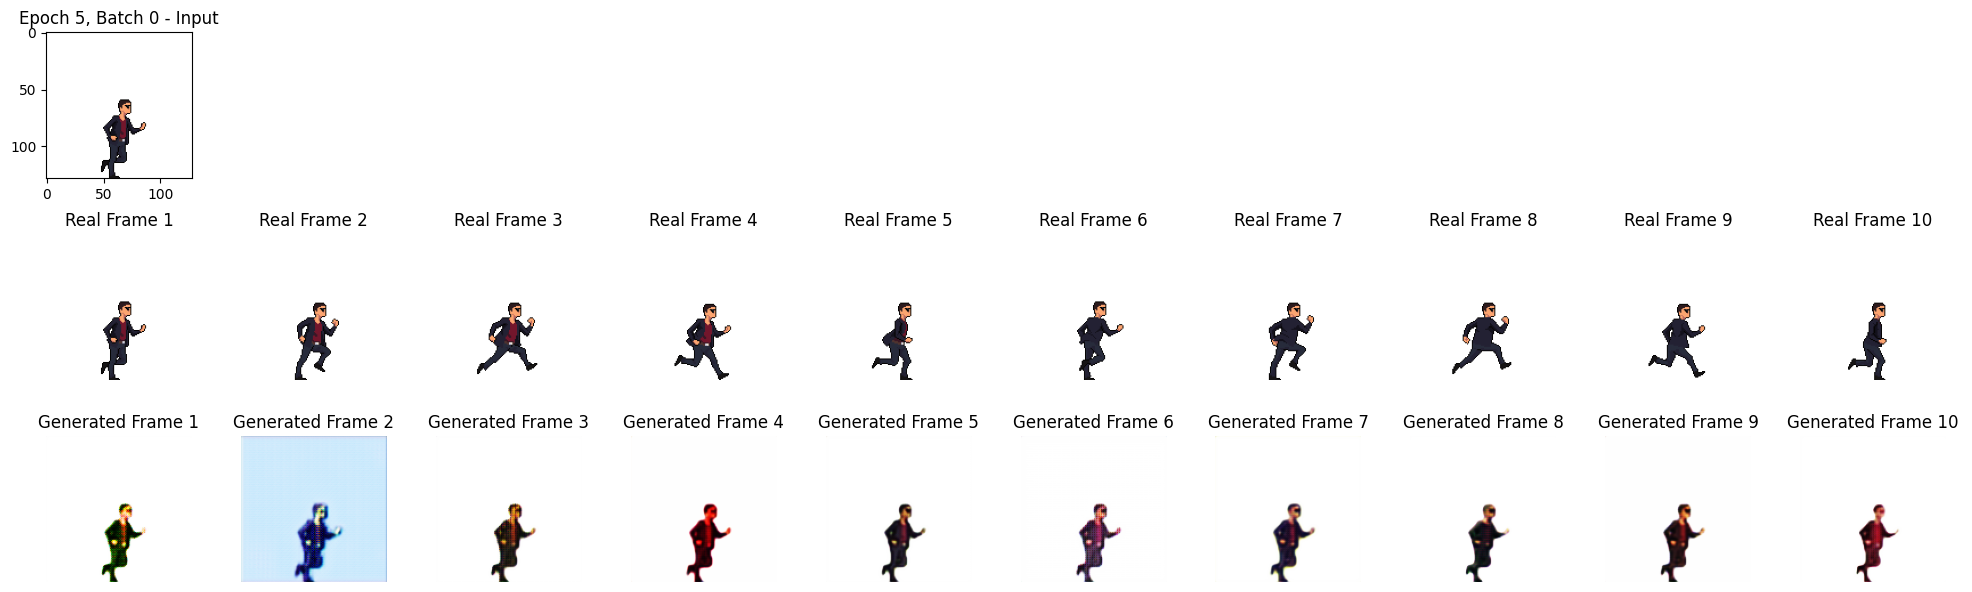

Processing Epoch 5/50:  10%|█         | 2/20 [00:09<01:23,  4.61s/it, Generator Loss=14.5, Discriminator Loss=0.385]

Generator Loss: 14.539904594421387, Discriminator Loss: 0.38526201248168945


Processing Epoch 5/50:  15%|█▌        | 3/20 [00:13<01:14,  4.39s/it, Generator Loss=15.3, Discriminator Loss=0.465]

Generator Loss: 15.282052993774414, Discriminator Loss: 0.46475839614868164


Processing Epoch 5/50:  20%|██        | 4/20 [00:17<01:08,  4.26s/it, Generator Loss=13.8, Discriminator Loss=0.665]

Generator Loss: 13.785682678222656, Discriminator Loss: 0.6647963523864746


Processing Epoch 5/50:  25%|██▌       | 5/20 [00:21<01:03,  4.24s/it, Generator Loss=13.6, Discriminator Loss=0.444]

Generator Loss: 13.626701354980469, Discriminator Loss: 0.44363969564437866


Processing Epoch 5/50:  30%|███       | 6/20 [00:25<00:58,  4.21s/it, Generator Loss=9.38, Discriminator Loss=0.519]

Generator Loss: 9.377013206481934, Discriminator Loss: 0.5186972618103027


Processing Epoch 5/50:  35%|███▌      | 7/20 [00:30<00:53,  4.15s/it, Generator Loss=9.93, Discriminator Loss=0.624]

Generator Loss: 9.928803443908691, Discriminator Loss: 0.6239322423934937


Processing Epoch 5/50:  40%|████      | 8/20 [00:34<00:49,  4.11s/it, Generator Loss=10.4, Discriminator Loss=0.427]

Generator Loss: 10.420591354370117, Discriminator Loss: 0.4266977906227112


Processing Epoch 5/50:  45%|████▌     | 9/20 [00:38<00:45,  4.10s/it, Generator Loss=10.3, Discriminator Loss=0.41] 

Generator Loss: 10.343721389770508, Discriminator Loss: 0.41019773483276367


Processing Epoch 5/50:  50%|█████     | 10/20 [00:42<00:40,  4.09s/it, Generator Loss=6.3, Discriminator Loss=0.864]

Generator Loss: 6.299841403961182, Discriminator Loss: 0.8635517954826355


Processing Epoch 5/50:  50%|█████     | 10/20 [00:46<00:40,  4.09s/it, Generator Loss=5.81, Discriminator Loss=0.439]

Generator Loss: 5.808004379272461, Discriminator Loss: 0.4389585852622986


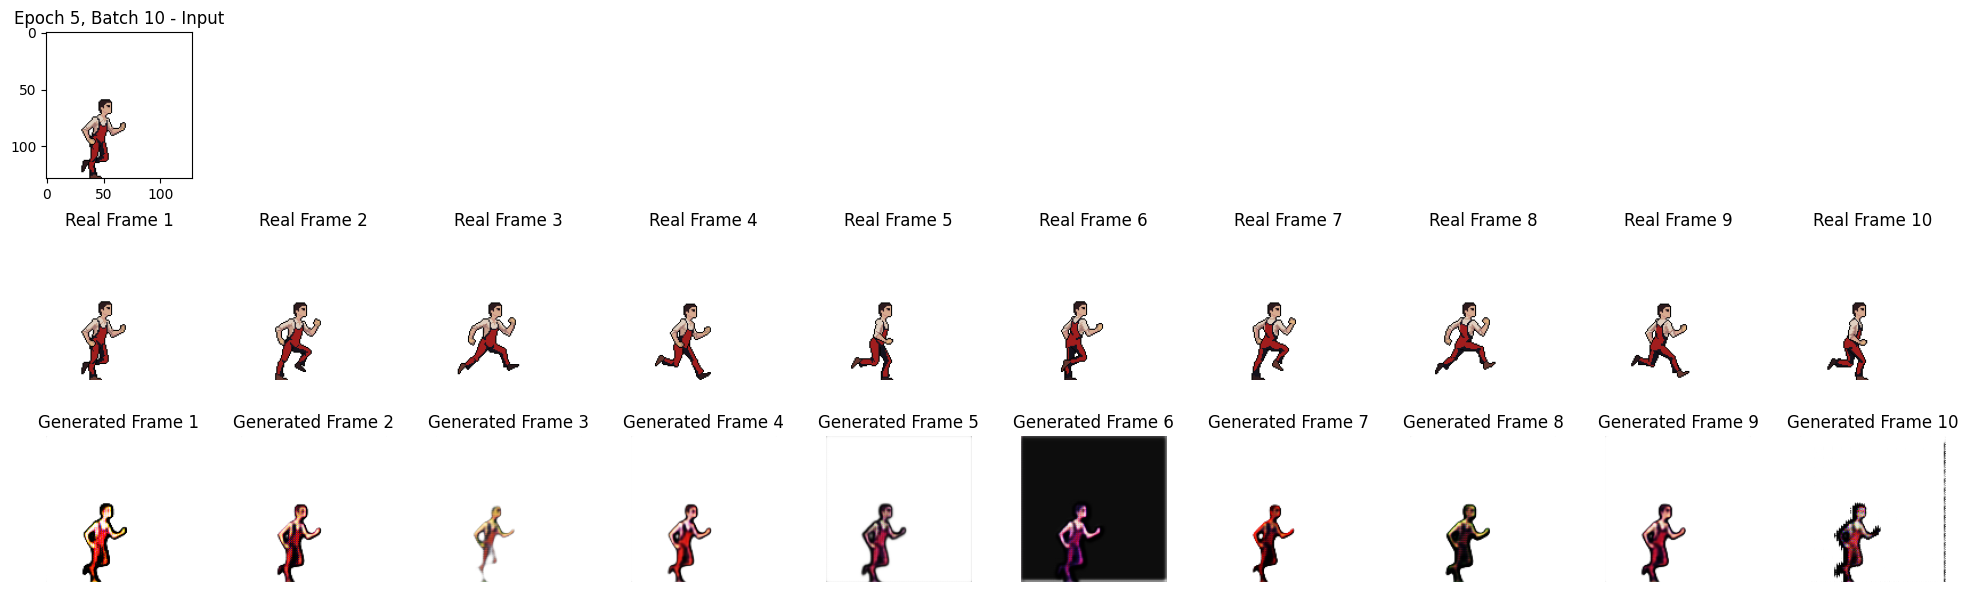

Processing Epoch 5/50:  60%|██████    | 12/20 [00:51<00:34,  4.32s/it, Generator Loss=7.28, Discriminator Loss=0.333]

Generator Loss: 7.278565883636475, Discriminator Loss: 0.33339494466781616


Processing Epoch 5/50:  65%|██████▌   | 13/20 [00:55<00:29,  4.22s/it, Generator Loss=6.44, Discriminator Loss=0.581]

Generator Loss: 6.440849304199219, Discriminator Loss: 0.5810526609420776


Processing Epoch 5/50:  70%|███████   | 14/20 [00:59<00:24,  4.12s/it, Generator Loss=7.39, Discriminator Loss=0.483]

Generator Loss: 7.38523006439209, Discriminator Loss: 0.48314762115478516


Processing Epoch 5/50:  75%|███████▌  | 15/20 [01:03<00:20,  4.10s/it, Generator Loss=7.38, Discriminator Loss=0.415]

Generator Loss: 7.375197410583496, Discriminator Loss: 0.4150906205177307


Processing Epoch 5/50:  80%|████████  | 16/20 [01:07<00:16,  4.11s/it, Generator Loss=8.1, Discriminator Loss=0.439] 

Generator Loss: 8.098597526550293, Discriminator Loss: 0.4385440945625305


Processing Epoch 5/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.05s/it, Generator Loss=7.46, Discriminator Loss=0.423]

Generator Loss: 7.457237243652344, Discriminator Loss: 0.42301660776138306


Processing Epoch 5/50:  90%|█████████ | 18/20 [01:15<00:08,  4.03s/it, Generator Loss=7.28, Discriminator Loss=0.515]

Generator Loss: 7.2825422286987305, Discriminator Loss: 0.5148738026618958


Processing Epoch 5/50:  95%|█████████▌| 19/20 [01:19<00:04,  4.05s/it, Generator Loss=5.22, Discriminator Loss=2.53] 

Generator Loss: 5.2209672927856445, Discriminator Loss: 2.5250418186187744


Generator Loss: 4.429099082946777, Discriminator Loss: 1.096219539642334
Epoch 6/50


Processing Epoch 6/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=18.4, Discriminator Loss=14.2]

Generator Loss: 18.436786651611328, Discriminator Loss: 14.200830459594727


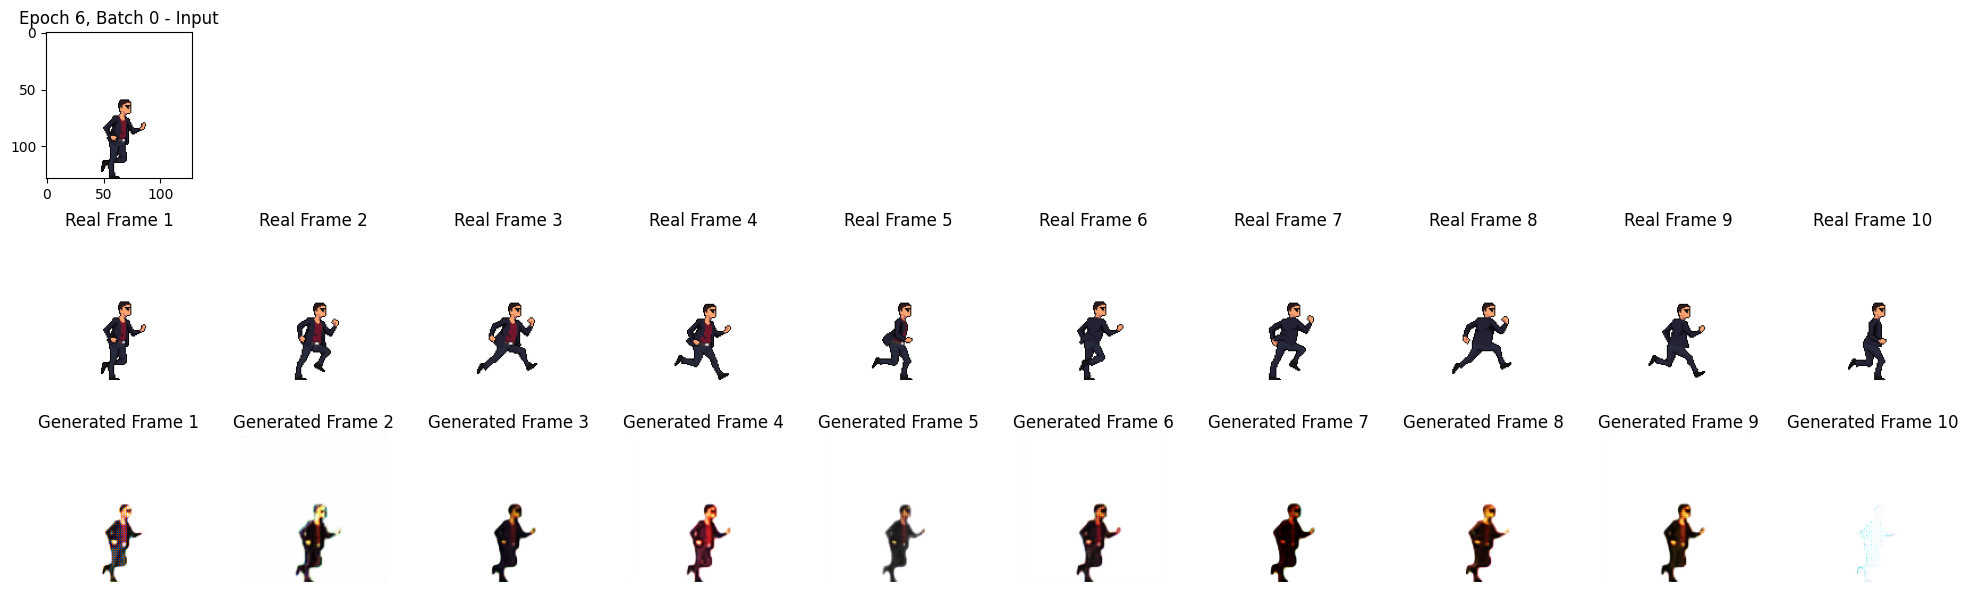

Processing Epoch 6/50:  10%|█         | 2/20 [00:09<01:24,  4.69s/it, Generator Loss=4.73, Discriminator Loss=2.07]

Generator Loss: 4.72931432723999, Discriminator Loss: 2.0668487548828125


Processing Epoch 6/50:  15%|█▌        | 3/20 [00:13<01:14,  4.39s/it, Generator Loss=6.8, Discriminator Loss=1.25] 

Generator Loss: 6.803625583648682, Discriminator Loss: 1.250272512435913


Processing Epoch 6/50:  20%|██        | 4/20 [00:17<01:07,  4.21s/it, Generator Loss=6.95, Discriminator Loss=1.31]

Generator Loss: 6.949235439300537, Discriminator Loss: 1.313143014907837


Processing Epoch 6/50:  25%|██▌       | 5/20 [00:21<01:02,  4.15s/it, Generator Loss=6.35, Discriminator Loss=0.732]

Generator Loss: 6.349553108215332, Discriminator Loss: 0.7323851585388184


Processing Epoch 6/50:  30%|███       | 6/20 [00:25<00:57,  4.13s/it, Generator Loss=4.76, Discriminator Loss=1.08] 

Generator Loss: 4.759875297546387, Discriminator Loss: 1.081176996231079


Processing Epoch 6/50:  35%|███▌      | 7/20 [00:29<00:52,  4.07s/it, Generator Loss=8.38, Discriminator Loss=0.909]

Generator Loss: 8.384068489074707, Discriminator Loss: 0.9087930917739868


Processing Epoch 6/50:  40%|████      | 8/20 [00:33<00:48,  4.04s/it, Generator Loss=6.78, Discriminator Loss=0.737]

Generator Loss: 6.775238037109375, Discriminator Loss: 0.7365795373916626


Processing Epoch 6/50:  45%|████▌     | 9/20 [00:37<00:44,  4.03s/it, Generator Loss=6.32, Discriminator Loss=0.514]

Generator Loss: 6.315616607666016, Discriminator Loss: 0.5140615701675415


Processing Epoch 6/50:  50%|█████     | 10/20 [00:41<00:40,  4.03s/it, Generator Loss=8.12, Discriminator Loss=1.98]

Generator Loss: 8.118915557861328, Discriminator Loss: 1.9817149639129639


Processing Epoch 6/50:  50%|█████     | 10/20 [00:45<00:40,  4.03s/it, Generator Loss=6.46, Discriminator Loss=0.807]

Generator Loss: 6.456316947937012, Discriminator Loss: 0.8074523210525513


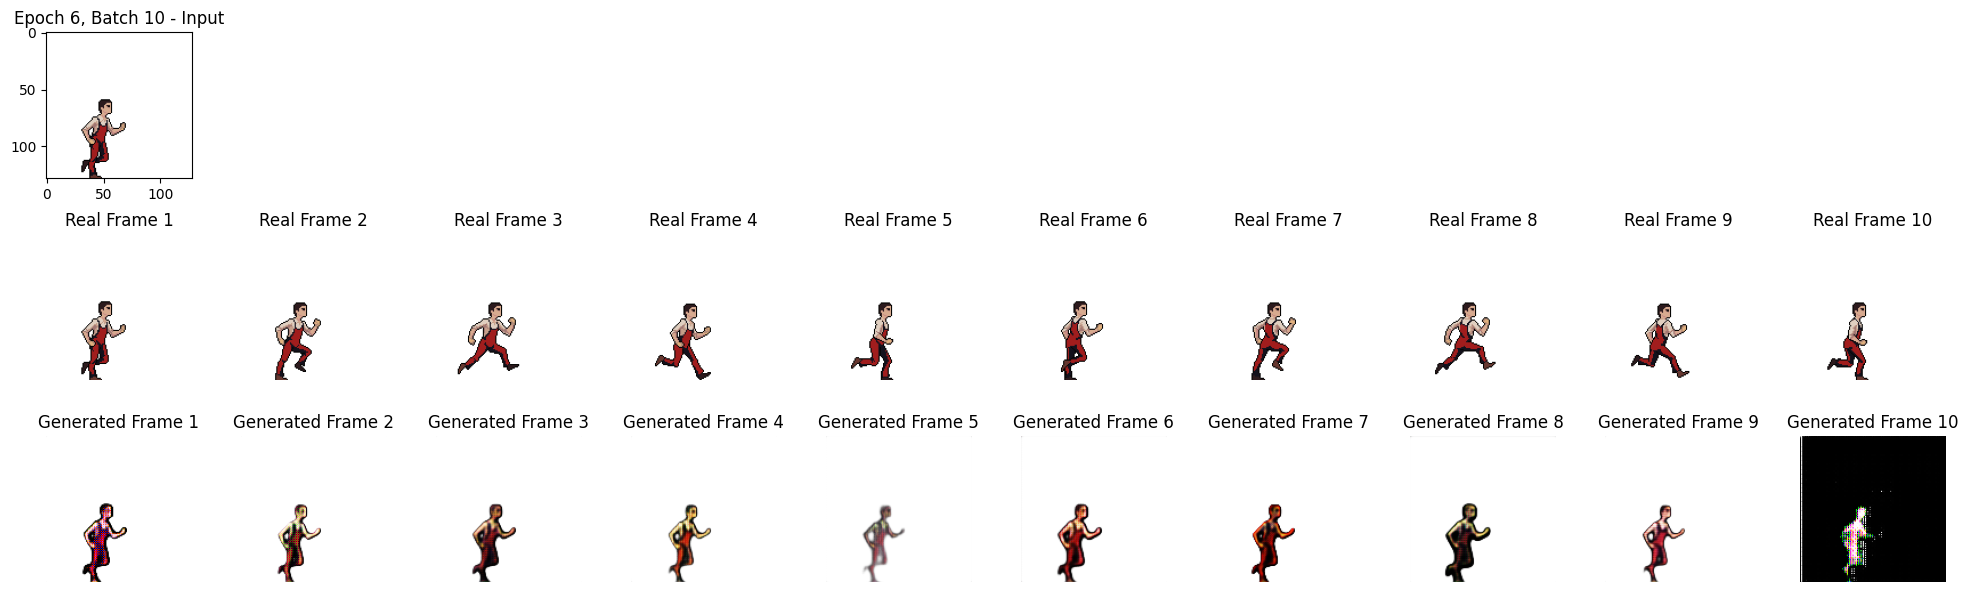

Processing Epoch 6/50:  60%|██████    | 12/20 [00:51<00:34,  4.35s/it, Generator Loss=5.9, Discriminator Loss=0.718] 

Generator Loss: 5.900308609008789, Discriminator Loss: 0.7181888222694397


Processing Epoch 6/50:  65%|██████▌   | 13/20 [00:55<00:29,  4.24s/it, Generator Loss=7.23, Discriminator Loss=0.82]

Generator Loss: 7.22876501083374, Discriminator Loss: 0.8197991251945496


Processing Epoch 6/50:  70%|███████   | 14/20 [00:59<00:24,  4.14s/it, Generator Loss=5.89, Discriminator Loss=0.72]

Generator Loss: 5.890326499938965, Discriminator Loss: 0.7196604609489441


Processing Epoch 6/50:  75%|███████▌  | 15/20 [01:03<00:20,  4.10s/it, Generator Loss=4.98, Discriminator Loss=0.659]

Generator Loss: 4.980473518371582, Discriminator Loss: 0.6591278910636902


Processing Epoch 6/50:  80%|████████  | 16/20 [01:07<00:16,  4.10s/it, Generator Loss=5.57, Discriminator Loss=0.676]

Generator Loss: 5.567220687866211, Discriminator Loss: 0.6757407188415527


Processing Epoch 6/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.06s/it, Generator Loss=7.27, Discriminator Loss=0.641]

Generator Loss: 7.274849891662598, Discriminator Loss: 0.6408061385154724


Processing Epoch 6/50:  90%|█████████ | 18/20 [01:15<00:08,  4.02s/it, Generator Loss=5.46, Discriminator Loss=0.54] 

Generator Loss: 5.459602355957031, Discriminator Loss: 0.5404559373855591


Processing Epoch 6/50:  95%|█████████▌| 19/20 [01:19<00:04,  4.04s/it, Generator Loss=5.24, Discriminator Loss=0.564]

Generator Loss: 5.236264705657959, Discriminator Loss: 0.5638641119003296


Generator Loss: 5.455627918243408, Discriminator Loss: 0.6265250444412231
Epoch 7/50


Processing Epoch 7/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=6.64, Discriminator Loss=0.534]

Generator Loss: 6.637655735015869, Discriminator Loss: 0.5342090725898743


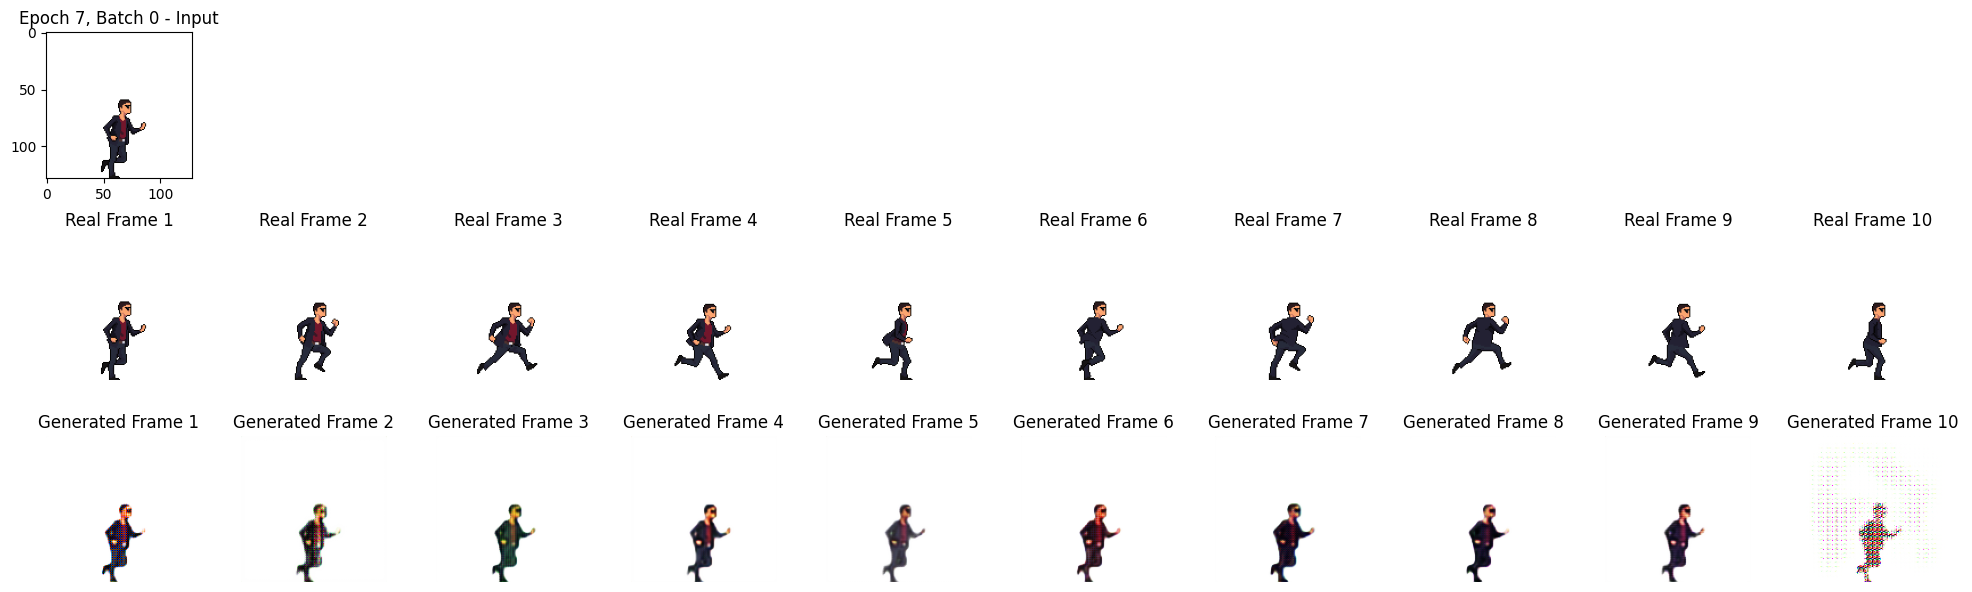

Processing Epoch 7/50:  10%|█         | 2/20 [00:09<01:21,  4.52s/it, Generator Loss=6.29, Discriminator Loss=0.525]

Generator Loss: 6.288793087005615, Discriminator Loss: 0.5245510935783386


Processing Epoch 7/50:  15%|█▌        | 3/20 [00:13<01:13,  4.32s/it, Generator Loss=5.51, Discriminator Loss=0.53] 

Generator Loss: 5.507073879241943, Discriminator Loss: 0.5296103358268738


Processing Epoch 7/50:  20%|██        | 4/20 [00:17<01:06,  4.18s/it, Generator Loss=6.43, Discriminator Loss=0.598]

Generator Loss: 6.431748867034912, Discriminator Loss: 0.5984015464782715


Processing Epoch 7/50:  25%|██▌       | 5/20 [00:21<01:01,  4.09s/it, Generator Loss=5.83, Discriminator Loss=0.461]

Generator Loss: 5.828788757324219, Discriminator Loss: 0.4605645537376404


Processing Epoch 7/50:  30%|███       | 6/20 [00:25<00:57,  4.08s/it, Generator Loss=5.64, Discriminator Loss=0.49] 

Generator Loss: 5.635695457458496, Discriminator Loss: 0.4904233515262604


Processing Epoch 7/50:  35%|███▌      | 7/20 [00:29<00:52,  4.06s/it, Generator Loss=9.53, Discriminator Loss=0.542]

Generator Loss: 9.53386402130127, Discriminator Loss: 0.5421333312988281


Processing Epoch 7/50:  40%|████      | 8/20 [00:33<00:48,  4.01s/it, Generator Loss=6.44, Discriminator Loss=0.449]

Generator Loss: 6.439601898193359, Discriminator Loss: 0.448604017496109


Processing Epoch 7/50:  45%|████▌     | 9/20 [00:37<00:44,  4.09s/it, Generator Loss=5.92, Discriminator Loss=0.432]

Generator Loss: 5.915634632110596, Discriminator Loss: 0.4317261278629303


Processing Epoch 7/50:  50%|█████     | 10/20 [00:41<00:40,  4.08s/it, Generator Loss=6.73, Discriminator Loss=0.529]

Generator Loss: 6.726233005523682, Discriminator Loss: 0.5293217897415161


Processing Epoch 7/50:  50%|█████     | 10/20 [00:45<00:40,  4.08s/it, Generator Loss=5.77, Discriminator Loss=0.618]

Generator Loss: 5.771709442138672, Discriminator Loss: 0.6177098155021667


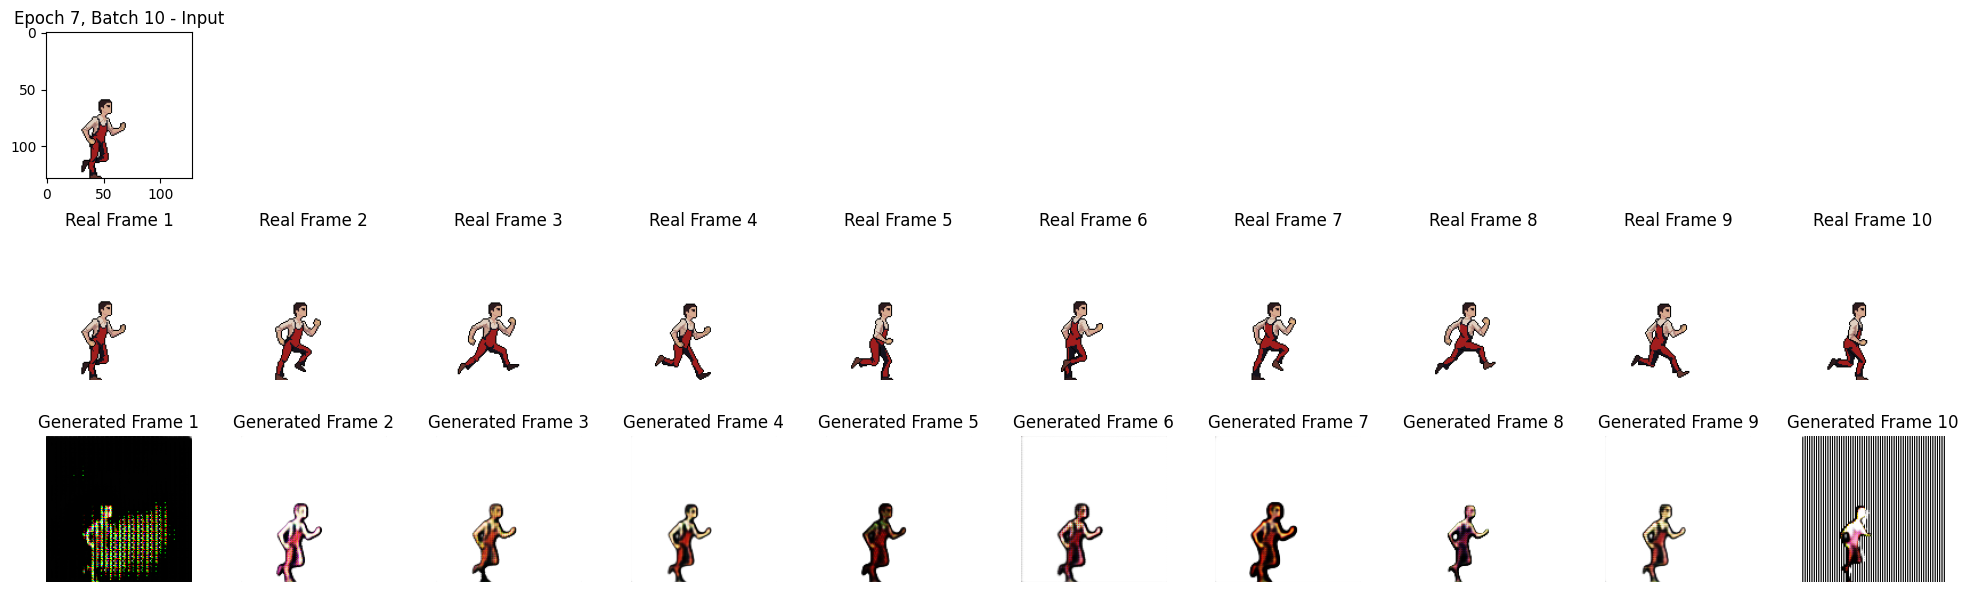

Processing Epoch 7/50:  60%|██████    | 12/20 [00:50<00:34,  4.29s/it, Generator Loss=8.9, Discriminator Loss=0.457] 

Generator Loss: 8.902583122253418, Discriminator Loss: 0.45653700828552246


Processing Epoch 7/50:  65%|██████▌   | 13/20 [00:54<00:29,  4.25s/it, Generator Loss=9.48, Discriminator Loss=0.559]

Generator Loss: 9.481507301330566, Discriminator Loss: 0.5587067604064941


Processing Epoch 7/50:  70%|███████   | 14/20 [00:58<00:25,  4.18s/it, Generator Loss=9.26, Discriminator Loss=0.484]

Generator Loss: 9.258916854858398, Discriminator Loss: 0.4841797351837158


Processing Epoch 7/50:  75%|███████▌  | 15/20 [01:02<00:20,  4.11s/it, Generator Loss=9.84, Discriminator Loss=0.749]

Generator Loss: 9.83738899230957, Discriminator Loss: 0.7492561936378479


Processing Epoch 7/50:  80%|████████  | 16/20 [01:06<00:16,  4.10s/it, Generator Loss=8.62, Discriminator Loss=0.458]

Generator Loss: 8.618053436279297, Discriminator Loss: 0.45846614241600037


Processing Epoch 7/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.09s/it, Generator Loss=8.82, Discriminator Loss=0.445]

Generator Loss: 8.81675910949707, Discriminator Loss: 0.4445020258426666


Processing Epoch 7/50:  90%|█████████ | 18/20 [01:14<00:08,  4.04s/it, Generator Loss=9.34, Discriminator Loss=0.378]

Generator Loss: 9.344358444213867, Discriminator Loss: 0.3775435984134674


Processing Epoch 7/50:  95%|█████████▌| 19/20 [01:18<00:04,  4.01s/it, Generator Loss=9.73, Discriminator Loss=0.526]

Generator Loss: 9.728534698486328, Discriminator Loss: 0.5256099104881287


Generator Loss: 10.42438793182373, Discriminator Loss: 0.4050343930721283
Epoch 8/50


Processing Epoch 8/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=10.1, Discriminator Loss=0.462]

Generator Loss: 10.137868881225586, Discriminator Loss: 0.4618222117424011


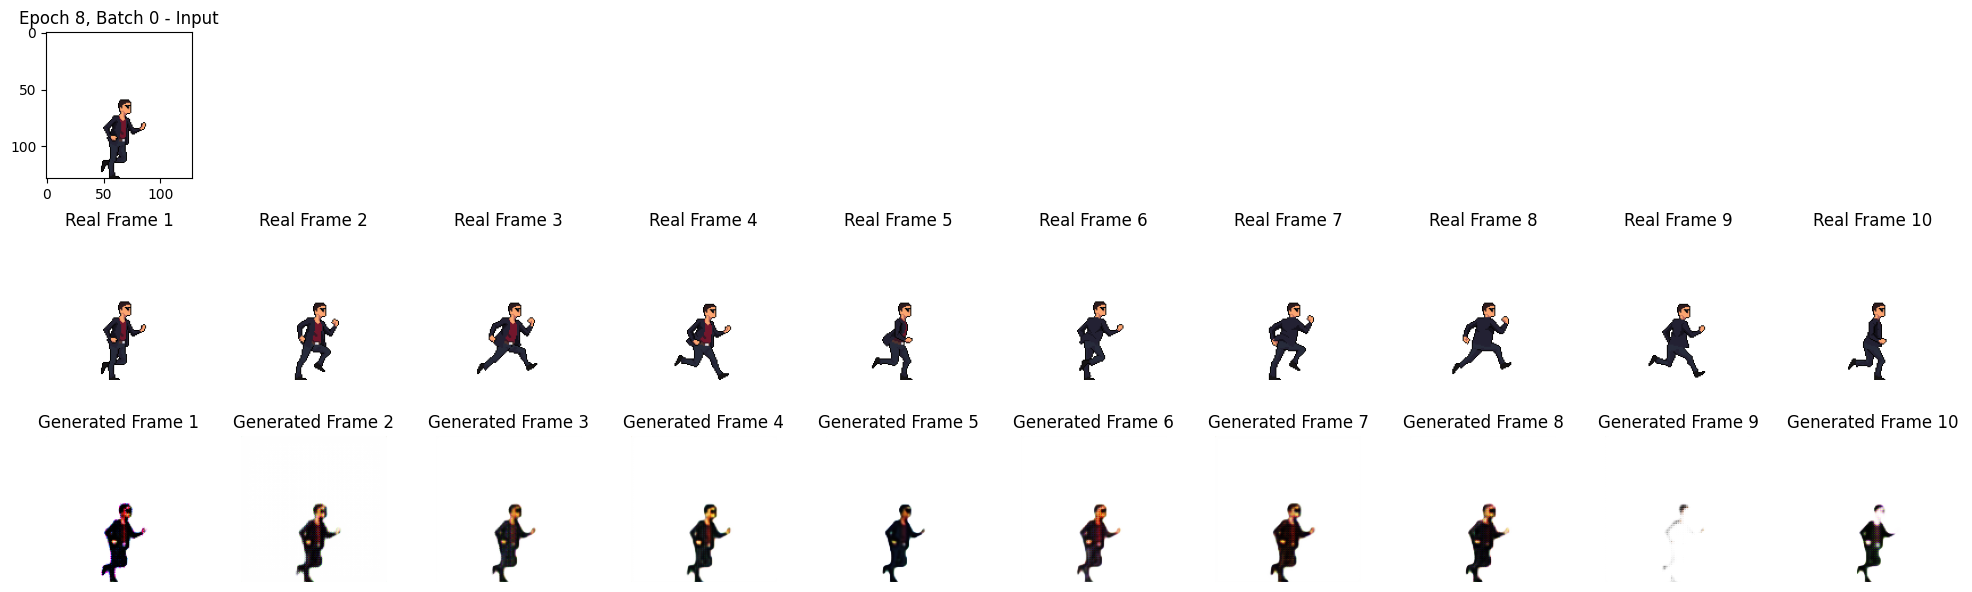

Processing Epoch 8/50:  10%|█         | 2/20 [00:09<01:25,  4.76s/it, Generator Loss=13.6, Discriminator Loss=0.458]

Generator Loss: 13.60827350616455, Discriminator Loss: 0.4583294987678528


Processing Epoch 8/50:  15%|█▌        | 3/20 [00:13<01:16,  4.47s/it, Generator Loss=10.2, Discriminator Loss=0.461]

Generator Loss: 10.217309951782227, Discriminator Loss: 0.4607508182525635


Processing Epoch 8/50:  20%|██        | 4/20 [00:17<01:08,  4.30s/it, Generator Loss=8.47, Discriminator Loss=0.53] 

Generator Loss: 8.471481323242188, Discriminator Loss: 0.52997225522995


Processing Epoch 8/50:  25%|██▌       | 5/20 [00:21<01:02,  4.17s/it, Generator Loss=9.05, Discriminator Loss=1.69]

Generator Loss: 9.04779052734375, Discriminator Loss: 1.6916465759277344


Processing Epoch 8/50:  30%|███       | 6/20 [00:25<00:57,  4.13s/it, Generator Loss=7.61, Discriminator Loss=0.436]

Generator Loss: 7.612745761871338, Discriminator Loss: 0.4362211227416992


Processing Epoch 8/50:  35%|███▌      | 7/20 [00:29<00:53,  4.12s/it, Generator Loss=7.95, Discriminator Loss=0.598]

Generator Loss: 7.945796966552734, Discriminator Loss: 0.598011314868927


Processing Epoch 8/50:  40%|████      | 8/20 [00:33<00:48,  4.07s/it, Generator Loss=7.73, Discriminator Loss=0.601]

Generator Loss: 7.726083278656006, Discriminator Loss: 0.6008354425430298


Processing Epoch 8/50:  45%|████▌     | 9/20 [00:37<00:44,  4.04s/it, Generator Loss=12.9, Discriminator Loss=0.395]

Generator Loss: 12.928057670593262, Discriminator Loss: 0.3952047824859619


Processing Epoch 8/50:  50%|█████     | 10/20 [00:41<00:40,  4.06s/it, Generator Loss=10.6, Discriminator Loss=0.47]

Generator Loss: 10.555928230285645, Discriminator Loss: 0.46967190504074097


Processing Epoch 8/50:  50%|█████     | 10/20 [00:45<00:40,  4.06s/it, Generator Loss=8.27, Discriminator Loss=0.423]

Generator Loss: 8.273898124694824, Discriminator Loss: 0.4226751923561096


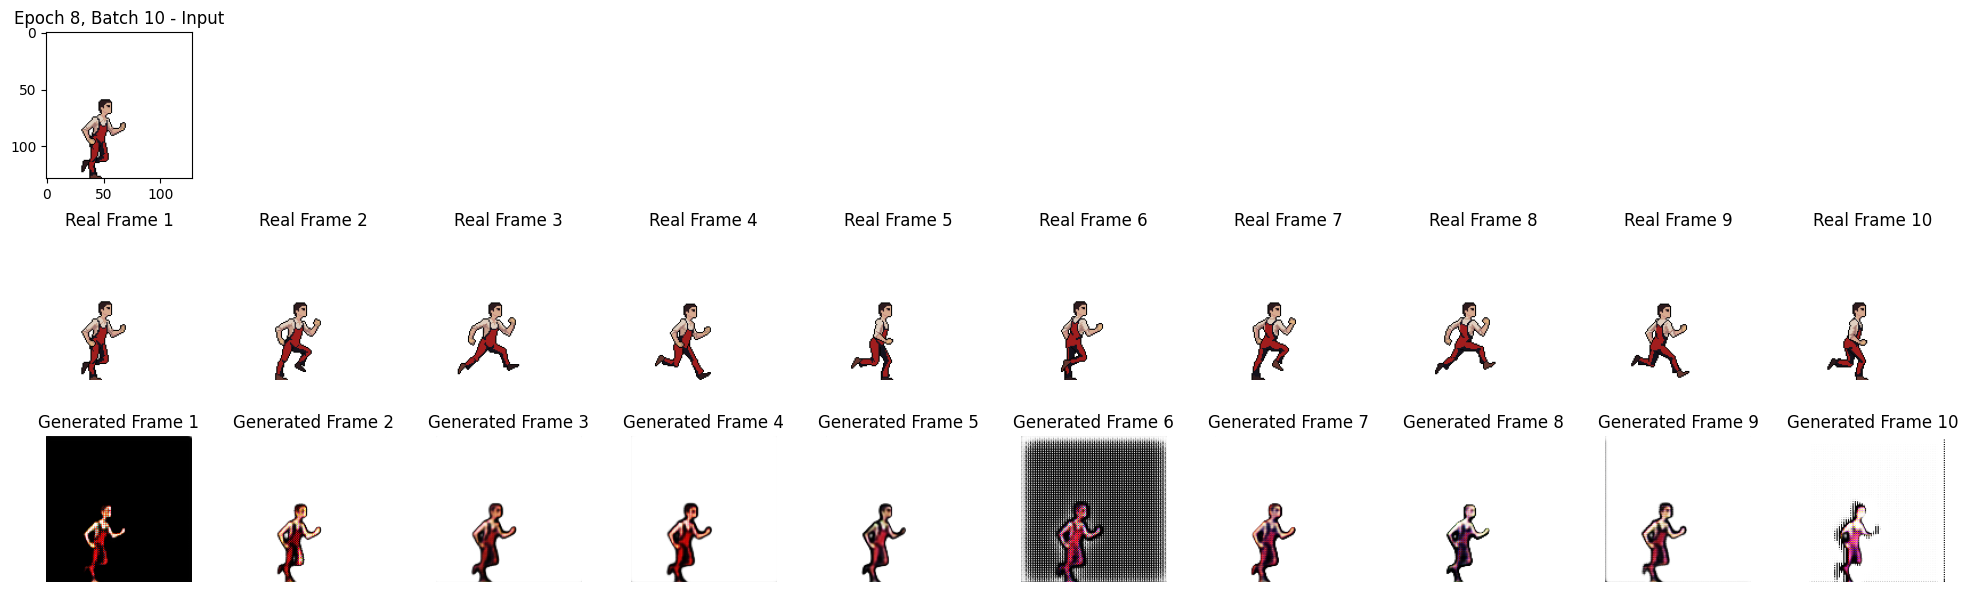

Processing Epoch 8/50:  60%|██████    | 12/20 [00:51<00:34,  4.28s/it, Generator Loss=8.71, Discriminator Loss=0.396]

Generator Loss: 8.70837688446045, Discriminator Loss: 0.39584192633628845


Processing Epoch 8/50:  65%|██████▌   | 13/20 [00:55<00:29,  4.21s/it, Generator Loss=8.59, Discriminator Loss=0.507]

Generator Loss: 8.586044311523438, Discriminator Loss: 0.5074090957641602


Processing Epoch 8/50:  70%|███████   | 14/20 [00:59<00:25,  4.18s/it, Generator Loss=8.14, Discriminator Loss=0.614]

Generator Loss: 8.136865615844727, Discriminator Loss: 0.6137846112251282


Processing Epoch 8/50:  75%|███████▌  | 15/20 [01:03<00:20,  4.10s/it, Generator Loss=8.18, Discriminator Loss=0.379]

Generator Loss: 8.180604934692383, Discriminator Loss: 0.3788551092147827


Processing Epoch 8/50:  80%|████████  | 16/20 [01:07<00:16,  4.06s/it, Generator Loss=8.16, Discriminator Loss=0.448]

Generator Loss: 8.157087326049805, Discriminator Loss: 0.4483295977115631


Processing Epoch 8/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.07s/it, Generator Loss=9.15, Discriminator Loss=0.446]

Generator Loss: 9.14879322052002, Discriminator Loss: 0.4464706778526306


Processing Epoch 8/50:  90%|█████████ | 18/20 [01:15<00:08,  4.07s/it, Generator Loss=14.1, Discriminator Loss=0.398]

Generator Loss: 14.103477478027344, Discriminator Loss: 0.39849627017974854


Processing Epoch 8/50:  95%|█████████▌| 19/20 [01:19<00:04,  4.02s/it, Generator Loss=14.7, Discriminator Loss=0.354]

Generator Loss: 14.651692390441895, Discriminator Loss: 0.3542404770851135


Generator Loss: 13.626960754394531, Discriminator Loss: 0.3560836613178253
Epoch 9/50


Processing Epoch 9/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=13.5, Discriminator Loss=0.421]

Generator Loss: 13.4578857421875, Discriminator Loss: 0.42080745100975037


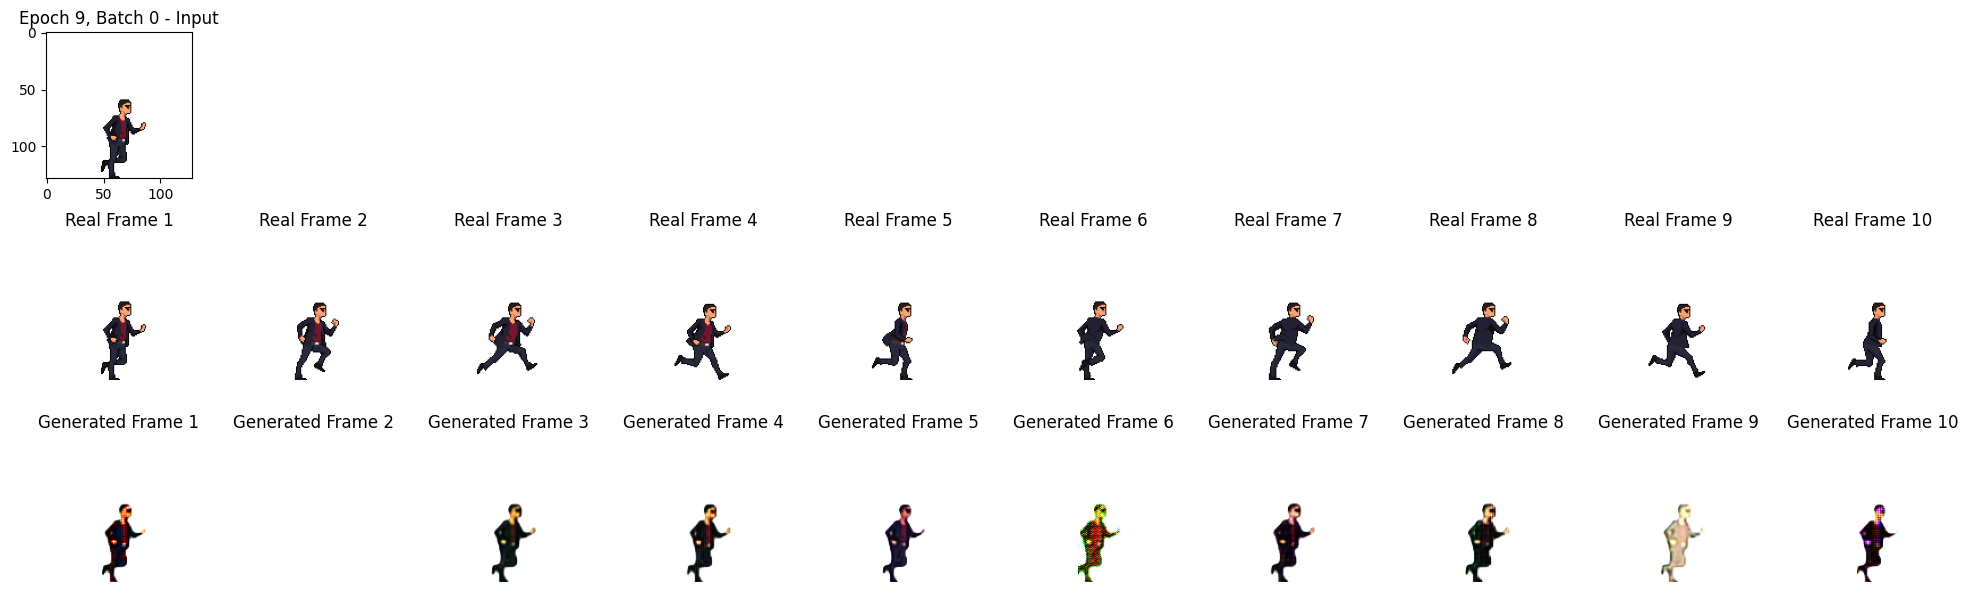

Processing Epoch 9/50:  10%|█         | 2/20 [00:09<01:25,  4.75s/it, Generator Loss=15.4, Discriminator Loss=0.412]

Generator Loss: 15.397481918334961, Discriminator Loss: 0.4123886525630951


Processing Epoch 9/50:  15%|█▌        | 3/20 [00:13<01:15,  4.43s/it, Generator Loss=14.4, Discriminator Loss=0.334]

Generator Loss: 14.449760437011719, Discriminator Loss: 0.33393770456314087


Processing Epoch 9/50:  20%|██        | 4/20 [00:17<01:08,  4.27s/it, Generator Loss=14.1, Discriminator Loss=0.413]

Generator Loss: 14.139959335327148, Discriminator Loss: 0.41266006231307983


Processing Epoch 9/50:  25%|██▌       | 5/20 [00:21<01:02,  4.16s/it, Generator Loss=10.4, Discriminator Loss=0.368]

Generator Loss: 10.377240180969238, Discriminator Loss: 0.3678033947944641


Processing Epoch 9/50:  30%|███       | 6/20 [00:25<00:57,  4.09s/it, Generator Loss=9.39, Discriminator Loss=0.364]

Generator Loss: 9.385234832763672, Discriminator Loss: 0.36376917362213135


Processing Epoch 9/50:  35%|███▌      | 7/20 [00:29<00:53,  4.09s/it, Generator Loss=11.1, Discriminator Loss=0.446]

Generator Loss: 11.113720893859863, Discriminator Loss: 0.44615888595581055


Processing Epoch 9/50:  40%|████      | 8/20 [00:33<00:48,  4.05s/it, Generator Loss=18.4, Discriminator Loss=0.342]

Generator Loss: 18.365556716918945, Discriminator Loss: 0.3415732979774475


Processing Epoch 9/50:  45%|████▌     | 9/20 [00:37<00:44,  4.01s/it, Generator Loss=9.19, Discriminator Loss=0.38] 

Generator Loss: 9.193395614624023, Discriminator Loss: 0.38013553619384766


Processing Epoch 9/50:  50%|█████     | 10/20 [00:41<00:40,  4.01s/it, Generator Loss=14.4, Discriminator Loss=0.517]

Generator Loss: 14.407183647155762, Discriminator Loss: 0.5174011588096619


Processing Epoch 9/50:  50%|█████     | 10/20 [00:45<00:40,  4.01s/it, Generator Loss=8.65, Discriminator Loss=0.378]

Generator Loss: 8.653447151184082, Discriminator Loss: 0.37814441323280334


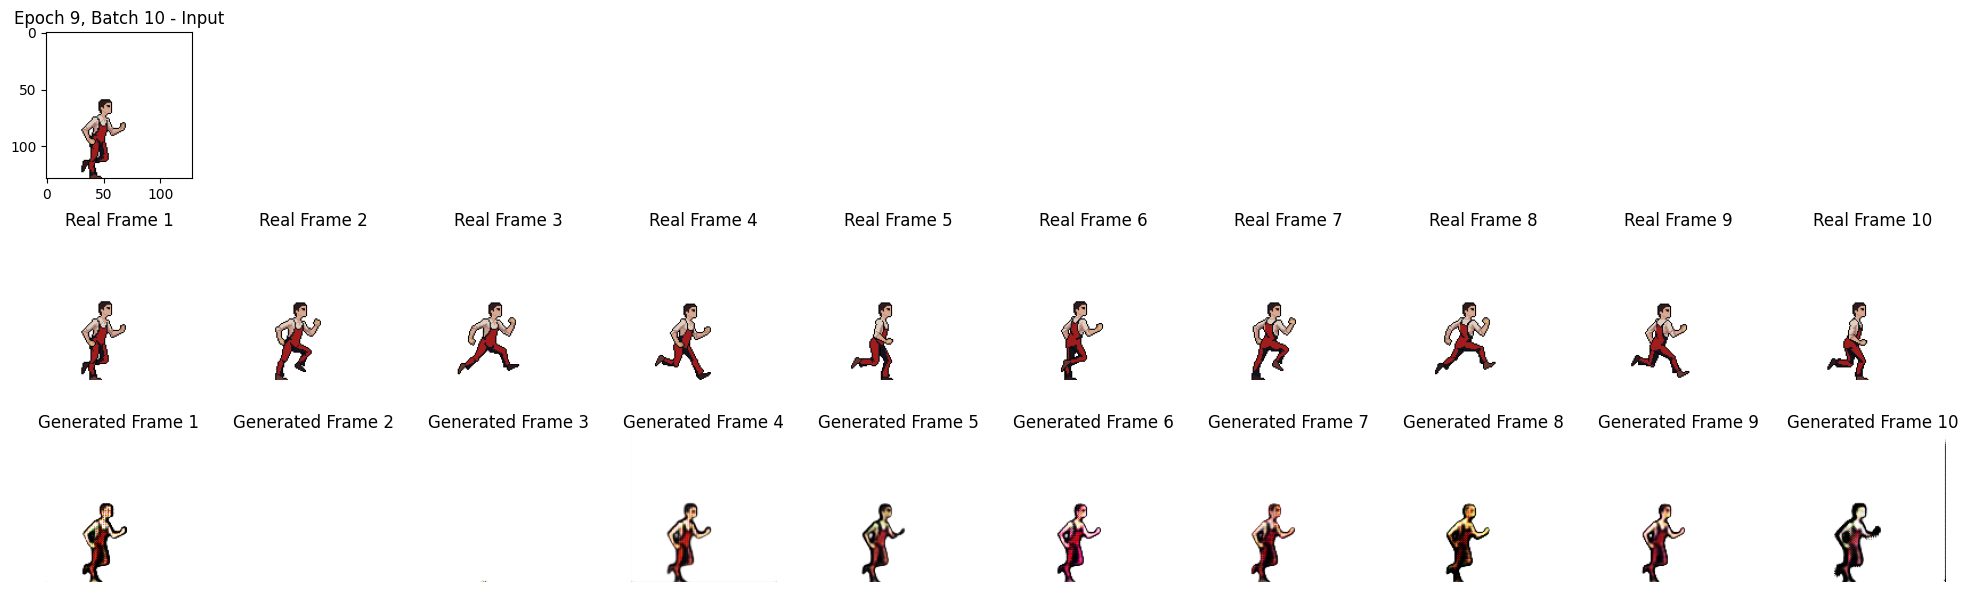

Processing Epoch 9/50:  60%|██████    | 12/20 [00:50<00:34,  4.27s/it, Generator Loss=11.5, Discriminator Loss=0.367]

Generator Loss: 11.45798110961914, Discriminator Loss: 0.3672097325325012


Processing Epoch 9/50:  65%|██████▌   | 13/20 [00:54<00:29,  4.19s/it, Generator Loss=10.4, Discriminator Loss=0.412]

Generator Loss: 10.426301956176758, Discriminator Loss: 0.4116535782814026


Processing Epoch 9/50:  70%|███████   | 14/20 [00:59<00:24,  4.16s/it, Generator Loss=8.81, Discriminator Loss=0.371]

Generator Loss: 8.80776309967041, Discriminator Loss: 0.37081122398376465


Processing Epoch 9/50:  75%|███████▌  | 15/20 [01:03<00:20,  4.15s/it, Generator Loss=9.06, Discriminator Loss=0.353]

Generator Loss: 9.060042381286621, Discriminator Loss: 0.3529011607170105


Processing Epoch 9/50:  80%|████████  | 16/20 [01:07<00:16,  4.11s/it, Generator Loss=10.3, Discriminator Loss=0.371]

Generator Loss: 10.323440551757812, Discriminator Loss: 0.3705841898918152


Processing Epoch 9/50:  85%|████████▌ | 17/20 [01:11<00:12,  4.11s/it, Generator Loss=10.3, Discriminator Loss=0.386]

Generator Loss: 10.311484336853027, Discriminator Loss: 0.3856794238090515


Processing Epoch 9/50:  90%|█████████ | 18/20 [01:15<00:08,  4.11s/it, Generator Loss=9.47, Discriminator Loss=0.699]

Generator Loss: 9.468873977661133, Discriminator Loss: 0.698711097240448


Processing Epoch 9/50:  95%|█████████▌| 19/20 [01:19<00:04,  4.10s/it, Generator Loss=8.45, Discriminator Loss=0.397]

Generator Loss: 8.448266983032227, Discriminator Loss: 0.3965545892715454


Generator Loss: 8.63180923461914, Discriminator Loss: 0.4116291403770447
Epoch 10/50


Processing Epoch 10/50:   0%|          | 0/20 [00:04<?, ?it/s, Generator Loss=9.94, Discriminator Loss=0.443]

Generator Loss: 9.944174766540527, Discriminator Loss: 0.4425418972969055


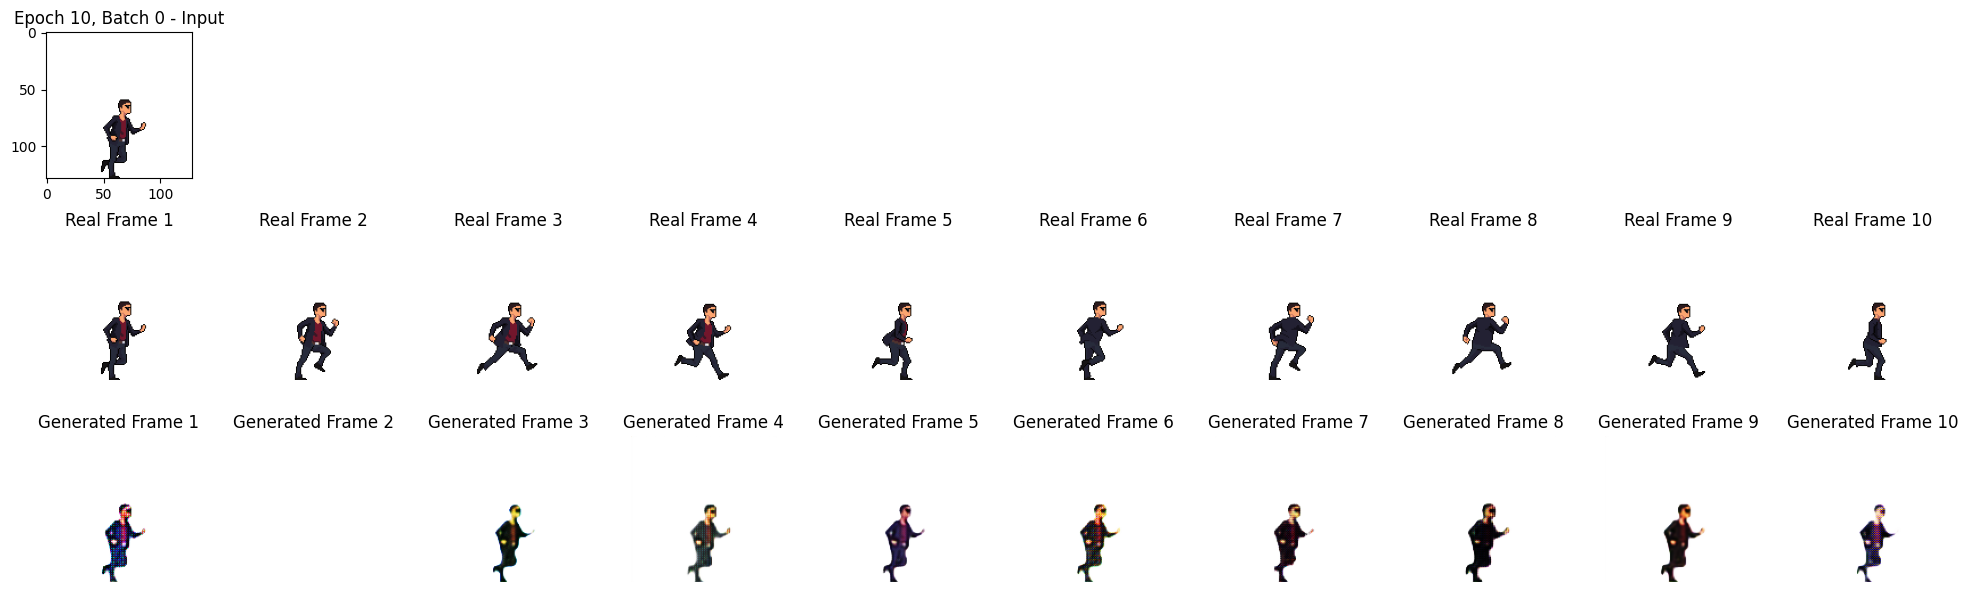

Processing Epoch 10/50:  10%|█         | 2/20 [00:09<01:22,  4.58s/it, Generator Loss=9.11, Discriminator Loss=0.396]

Generator Loss: 9.113649368286133, Discriminator Loss: 0.39563772082328796


Processing Epoch 10/50:  15%|█▌        | 3/20 [00:13<01:13,  4.33s/it, Generator Loss=8.66, Discriminator Loss=0.568]

Generator Loss: 8.658543586730957, Discriminator Loss: 0.5681909918785095


Processing Epoch 10/50:  20%|██        | 4/20 [00:17<01:08,  4.25s/it, Generator Loss=16.8, Discriminator Loss=0.429]

Generator Loss: 16.79045295715332, Discriminator Loss: 0.4286617338657379


Processing Epoch 10/50:  25%|██▌       | 5/20 [00:21<01:02,  4.18s/it, Generator Loss=13.2, Discriminator Loss=0.432]

Generator Loss: 13.217107772827148, Discriminator Loss: 0.4322029650211334


Processing Epoch 10/50:  30%|███       | 6/20 [00:25<00:57,  4.12s/it, Generator Loss=12.7, Discriminator Loss=0.432]

Generator Loss: 12.65292739868164, Discriminator Loss: 0.4317026734352112


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        # 모델 초기화
        sequence_length = 10
        generators = [Ayo_Generator(sequence_length=1) for _ in range(sequence_length)]
        discriminator = Ayo_Discriminator()

        # generators 리스트를 train_gan_per_frame 함수에 전달
        train_gan_per_frame(generators, discriminator, combined_dataset, epochs=50, target_frames=10)
else:
    print('NO GPU')

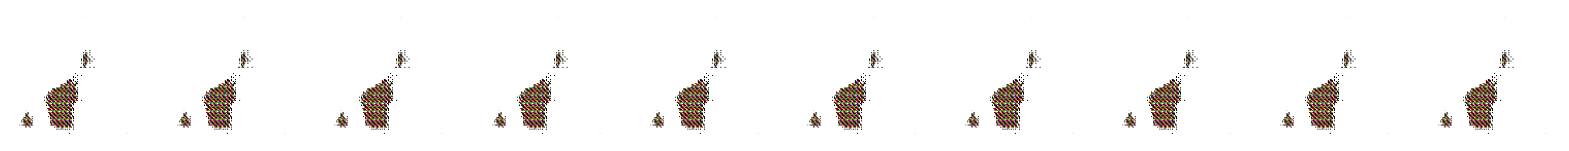

In [159]:
# 테스트할 첫 번째 프레임 로드 (일반적으로 학습 데이터의 첫 번째 프레임과 유사한 구조)
test_input_image = tf.expand_dims(combined_dataset[0, 0], axis=0)
test_input_image = tf.cast(test_input_image, tf.float32) / 127.5 - 1  # [0, 1] -> [-1, 1]로 스케일링

# GIF 생성 및 시각화
generate_gif(generator, test_input_image, sequence_length=10)